# chips-net analysis

This notebook contains the full analysis of chipsnet showing the full path taken to the final version...

## Finding the best models
- [x] [Exploring the data](#explore)
- [x] [Which training sample is best?](#sample)
- [x] [Which image representation is best?](#repr)
- [x] [Which channel configuration is best?](#channel)
- [x] [Which categorisation is best?](#cat)
- [x] [Does escapes help cosmic classifier?](#cosmic)
- [x] [Does primary count help beam classifier?](#beam)
- [x] [Does lepton/hadronic energy help neutrino energy estimation?](#energy_chan)
- [x] [Does vertex/escapes energy help neutrino energy estimation?](#energy_par)
- [ ] [Final performance and comparison with old reco/pid](#final)

## Explainability and resilience
- [ ] [Model calibration sensitivity: factor](#calib_factor)
- [ ] [Model calibration sensitivity: abs](#calib_abs)
- [ ] [Model calibration sensitivity: noise](#calib_noise)
- [ ] [Clustering: cosmic classification](#cosmic_cluster)
- [ ] [Clustering: beam classification](#beam_cluster)
- [ ] [Explanation: cosmic/beam/energy](#explain)

In [ ]:
# Default input parameters for this notebook, they are overridden by 'papermill' at runtime if specified
config_path = "./config/analysis/config.yaml"
save_path = "./data/output/"
nuel_map_file = "/unix/chips/jtingey/prod/nuel_all_numuflux/map/chips_1200/selected_000_sim_map.root"
numu_map_file = "/unix/chips/jtingey/prod/numu_all_numuflux/map/chips_1200/selected_000_sim_map.root"
cosmic_map_file = "/unix/chips/jtingey/prod/cosmics/map/chips_1200/selected_000_sim_map.root"
old_nuel_file = "./data/input/old_reco/old_reco_el.root"
old_numu_file = "./data/input/eld_reco/old_reco_mu.root"
vac_osc_file_zero_f = "./data/input/oscillations/vac_osc_cp_zero.root"
vac_osc_file_plus_f = "./data/input/oscillations/vac_osc_cp_plushalfpi.root"
vac_osc_file_minus_f = "./data/input/oscillations/vac_osc_cp_minushalfpi.root"
matter_osc_file_zero_f = "./data/input/oscillations/matter_osc_cp_zero.root"
matter_osc_file_plus_f = "./data/input/oscillations/matter_osc_cp_plushalfpi.root"
matter_osc_file_minus_f = "./data/input/oscillations/matter_osc_cp_minushalfpi.root"
total_flux_events = 1968000
total_uniform_events = 3500000
total_cosmic_events = 1975000

In [2]:
# Standard inports
import os
import logging
import importlib
import copy

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import mplhep as hep
import uproot

# Setup Tensorflow with correct logging and GPU's for inference
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.disable(logging.CRITICAL)
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if tf.config.list_physical_devices('GPU'):
    try:  # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:  # Memory growth must be set before GPUs have been initialized
        print(e)

import chipsnet.config
import chipsnet.data
import chipsnet.models
import chipsnet.utils
import chipsnet.plotting

# Setup matplotlib style using mplhep
extra_styling = {
    "text.usetex": True,
    "pgf.texsystem": "pdflatex",
    "pgf.rcfonts": False,
    "font.family": "serif",
    "font.serif": "Computer Modern Roman",
    "axes.xmargin": 0
}

style = hep.style.ROOT
del style['xaxis.labellocation']
del style['yaxis.labellocation']
plt.style.use([style, extra_styling])

In [3]:
# Reload method to import chipsnet modules on the fly if changes are made to them
config = chipsnet.config.get(config_path)
def reload():
    importlib.reload(chipsnet.config)
    importlib.reload(chipsnet.data)
    importlib.reload(chipsnet.models)
    importlib.reload(chipsnet.utils)
    importlib.reload(chipsnet.plotting)
    config = chipsnet.config.get(config_path)

# Finding the best models

<a id='explore'></a>

## Exploring the data (explore)

In [4]:
s_both_ev, s_both_out = chipsnet.utils.evaluate(config, "sample_both_cosmic")
s_flux_ev, s_flux_out = chipsnet.utils.evaluate(config, "sample_flux_cosmic")
s_uniform_ev, s_uniform_out = chipsnet.utils.evaluate(config, "sample_uniform_cosmic")
flux_ev, flux_out = chipsnet.utils.evaluate(config, "flux_cosmic")


************************ Evaluating sample_both_cosmic ************************
Weights: (0,0.00000), (0,0.00000), (96489,0.03475), (0,0.00000), (70003,17.29494)
Cuts:    (63762,0.95667), (68105,0.93013), (32862,0.71244), (14301,0.20429)
took 148.71 seconds

************************ Evaluating sample_flux_cosmic ************************
Weights: (0,0.00000), (0,0.00000), (71827,0.04668), (0,0.00000), (117466,10.30679)
Cuts:    (54728,0.94461), (56767,0.91380), (12249,0.66300), (24448,0.20813)
took 161.24 seconds

************************ Evaluating sample_uniform_cosmic ************************
Weights: (0,0.00000), (0,0.00000), (89764,0.03736), (0,0.00000), (85591,14.14515)
Cuts:    (51124,0.95934), (58345,0.92993), (41287,0.75927), (17823,0.20823)
took 201.94 seconds

************************ Evaluating flux_cosmic ************************
Weights: (23343,0.00167), (37834,0.00007), (40191,0.08343), (68835,0.00107), (48820,24.79922)
Cuts:    (80343,0.96045), (87743,0.93328), (20340,0

In [5]:
# Get oscillation arrays...
vac_osc_file_zero = uproot.open(vac_osc_file_zero_f)
vac_osc_file_plus = uproot.open(vac_osc_file_plus_f)
vac_osc_file_minus = uproot.open(vac_osc_file_minus_f)
matter_osc_file_zero = uproot.open(matter_osc_file_zero_f)
matter_osc_file_plus = uproot.open(matter_osc_file_plus_f)
matter_osc_file_minus = uproot.open(matter_osc_file_minus_f)

vac_numu_prop_zero = vac_osc_file_zero["hist_mumu"].values[113]
vac_nuel_prop_zero = vac_osc_file_zero["hist_mue"].values[113]
vac_numu_prop_plus = vac_osc_file_plus["hist_mumu"].values[113]
vac_nuel_prop_plus = vac_osc_file_plus["hist_mue"].values[113]
vac_numu_prop_minus = vac_osc_file_minus["hist_mumu"].values[113]
vac_nuel_prop_minus = vac_osc_file_minus["hist_mue"].values[113]

matter_numu_prop_zero = matter_osc_file_zero["hist_mumu"].values
matter_nuel_prop_zero = matter_osc_file_zero["hist_mue"].values
matter_numu_prop_plus = matter_osc_file_plus["hist_mumu"].values
matter_nuel_prop_plus = matter_osc_file_plus["hist_mue"].values
matter_numu_prop_minus = matter_osc_file_minus["hist_mumu"].values
matter_nuel_prop_minus = matter_osc_file_minus["hist_mue"].values

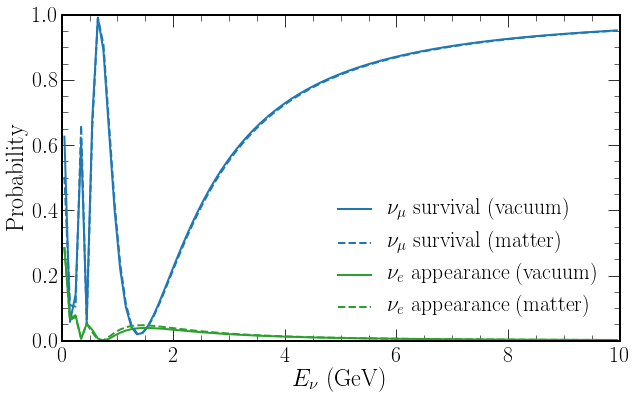

In [6]:
energies = np.arange(0.05, 10.05, 0.1)
fig, axs = plt.subplots(1, 1, figsize=(10, 6), gridspec_kw={"hspace": 0.3})
axs.plot(energies, vac_numu_prop_zero, color="tab:blue", linewidth=2)
axs.plot(energies, vac_nuel_prop_zero, color="tab:green", linewidth=2)
axs.plot(energies, matter_numu_prop_zero, color="tab:blue", linewidth=2, linestyle="dashed")
axs.plot(energies, matter_nuel_prop_zero, color="tab:green", linewidth=2, linestyle="dashed")
axs.set_ylim(0, 1)
axs.set_xlim(0, 10)
axs.set_xlabel(r"$E_{\nu}$ (GeV)", fontsize=24)
axs.set_ylabel(r"Probability", fontsize=24)
vac_numu = Line2D([0], [0], color="tab:blue", linewidth=2, linestyle="solid", label=r"$\nu_{\mu}$ survival (vacuum)")
vac_nuel = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label=r"$\nu_{e}$ appearance (vacuum)")
matter_numu = Line2D([0], [0], color="tab:blue", linewidth=2, linestyle="dashed", label=r"$\nu_{\mu}$ survival (matter)")
matter_nuel = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="dashed", label=r"$\nu_{e}$ appearance (matter)")
axs.legend(handles=[vac_numu, matter_numu, vac_nuel, matter_nuel], loc="lower right")
chipsnet.plotting.save(save_path + "explore_osc_vac_vs_matter_probs")

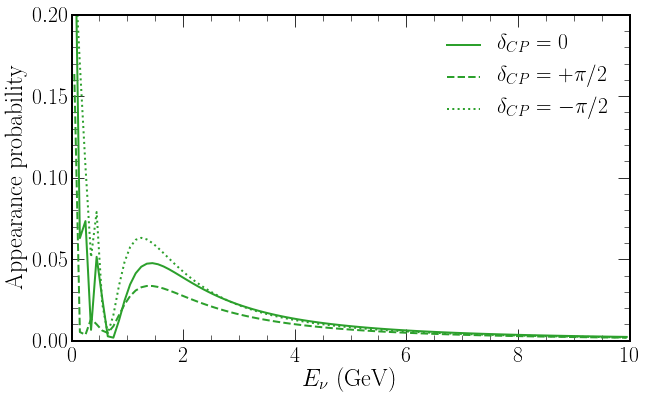

In [7]:
energies = np.arange(0.05, 10.05, 0.1)
fig, axs = plt.subplots(1, 1, figsize=(10, 6), gridspec_kw={"hspace": 0.3})
axs.plot(energies, matter_nuel_prop_zero, color="tab:green", linewidth=2)
axs.plot(energies, matter_nuel_prop_plus, color="tab:green", linewidth=2, linestyle="dashed")
axs.plot(energies, matter_nuel_prop_minus, color="tab:green", linewidth=2, linestyle="dotted")
axs.set_ylim(0, 0.2)
axs.set_xlim(0, 10)
axs.set_xlabel(r"$E_{\nu}$ (GeV)", fontsize=24)
axs.set_ylabel(r"Appearance probability", fontsize=24)
zero_cp = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label=r"$\delta_{CP}=0$")
plus_cp = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="dashed", label=r"$\delta_{CP}=+\pi/2$")
minus_cp = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="dotted", label=r"$\delta_{CP}=-\pi/2$")
axs.legend(handles=[zero_cp, plus_cp, minus_cp], loc="upper right")
chipsnet.plotting.save(save_path + "explore_osc_cp_probs")

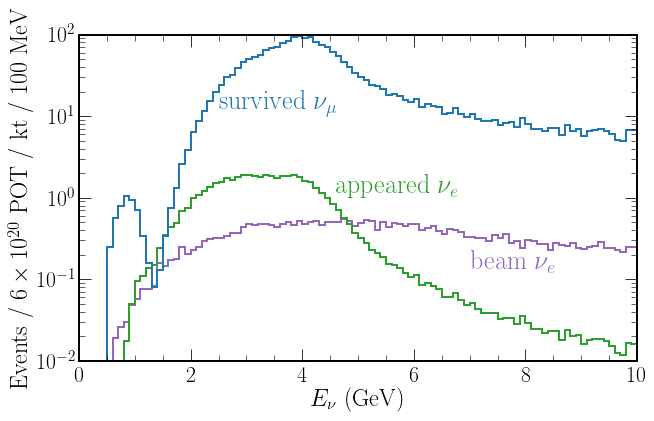

In [8]:
nuel_ev = flux_ev[
    (flux_ev[chipsnet.data.MAP_NU_TYPE["name"]] == 0) & 
    (flux_ev[chipsnet.data.MAP_COSMIC_CAT["name"]] == 0) &
    (flux_ev["t_sample_type"] == 0)
]
osc_nuel_ev = flux_ev[
    (flux_ev[chipsnet.data.MAP_NU_TYPE["name"]] == 0) & 
    (flux_ev[chipsnet.data.MAP_COSMIC_CAT["name"]] == 0) &
    (flux_ev["t_sample_type"] == 1)
]
numu_ev = flux_ev[
    (flux_ev[chipsnet.data.MAP_NU_TYPE["name"]] == 1) &
    (flux_ev[chipsnet.data.MAP_COSMIC_CAT["name"]] == 0) &
    (flux_ev["t_sample_type"] == 0)
]

fig, axs = plt.subplots(1, 1, figsize=(10, 6), gridspec_kw={"hspace": 0.3})
axs.hist(nuel_ev["t_nu_energy"]/1000, weights=nuel_ev["w"], range=(0, 10), bins=100, color='tab:purple', histtype='step', linewidth=2)
axs.hist(osc_nuel_ev["t_nu_energy"]/1000, weights=osc_nuel_ev["w"], range=(0, 10), bins=100, color='tab:green', histtype='step', linewidth=2)
axs.hist(numu_ev["t_nu_energy"]/1000, weights=numu_ev["w"], range=(0, 10), bins=100, color='tab:blue', histtype='step', linewidth=2)
axs.text(2.5, 11, r"survived $\nu_{\mu}$", color='tab:blue')
axs.text(4.6, 1, r"appeared $\nu_{e}$", color='tab:green')
axs.text(7, 0.12, r"beam $\nu_{e}$", color='tab:purple')
axs.set_yscale('log')
axs.set_xlabel(r"$E_{\nu}$ (GeV)", fontsize=24)
axs.set_ylabel(r"Events / $6\times10^{20}$ POT / kt / 100 MeV", fontsize=24)
axs.set_ylim(10e-3, 10e1)
chipsnet.plotting.save(save_path + "explore_osc_fluxes")

In [9]:
def plot_training_sample(events, scale, save_name):
    data = [
        len(events[events["t_all_cat"] == i])
        for i in range(len(chipsnet.data.MAP_ALL_CAT["labels"]))
    ]
    data = [x * scale for x in data]

    labels = chipsnet.data.MAP_ALL_CAT["labels"]
    cats = np.arange(len(labels))
    width = 1

    fig, axs = plt.subplots(1, 1, figsize=(12, 5), gridspec_kw={"hspace": 0.3})
    axs.bar(cats, data, color="tab:blue", width=width, label="training sample", edgecolor='black')
    axs.set_xticks(cats)
    axs.set_xticklabels(labels, fontsize=18, rotation="vertical")
    axs.set_ylabel("Training events")
    axs.set_yscale('log')
    axs.set_ylim(10e2, 10e6)
    chipsnet.plotting.save(save_name)

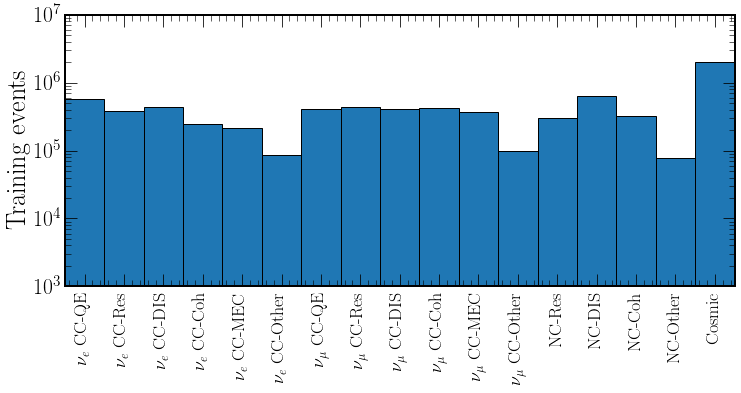

In [10]:
plot_training_sample(s_both_ev, (total_flux_events+total_uniform_events+total_cosmic_events) / config.eval.examples, save_path + "explore_both_sample")

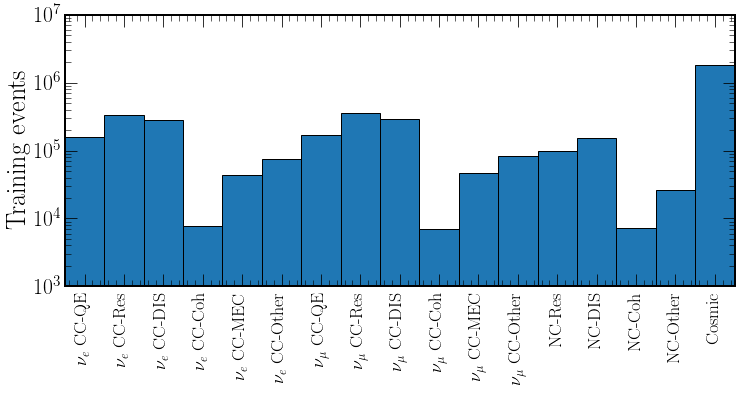

In [11]:
plot_training_sample(s_flux_ev, (total_flux_events+total_cosmic_events) / config.eval.examples, save_path + "explore_flux_sample")

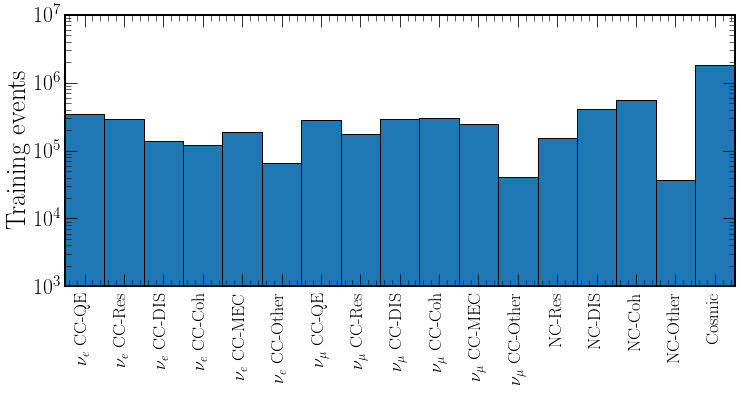

In [12]:
plot_training_sample(s_uniform_ev, (total_uniform_events+total_cosmic_events) / config.eval.examples, save_path + "explore_uniform_sample")

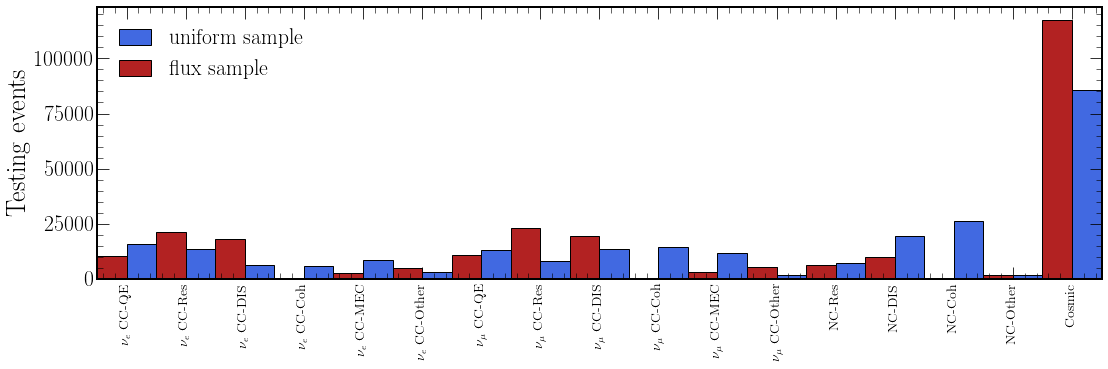

In [13]:
chipsnet.plotting.plot_cats(s_uniform_ev, s_flux_ev, chipsnet.data.MAP_ALL_CAT, save_path)

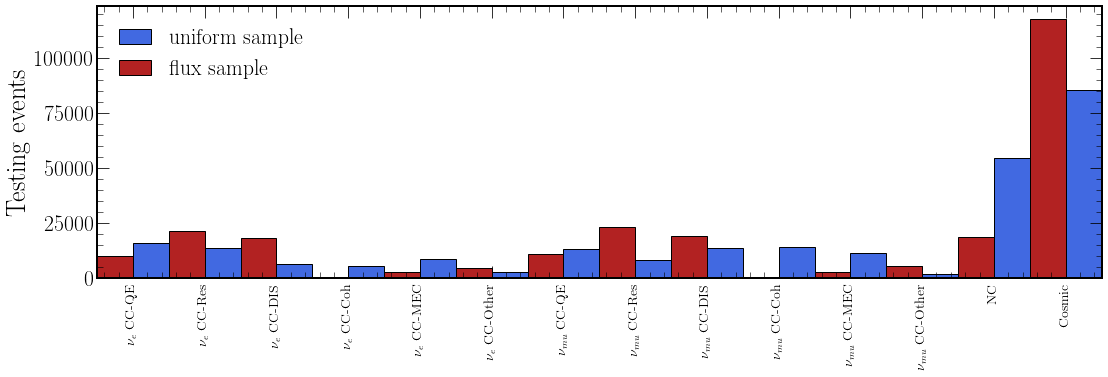

In [14]:
chipsnet.plotting.plot_cats(s_uniform_ev, s_flux_ev, chipsnet.data.MAP_NC_COMB_CAT, save_path)

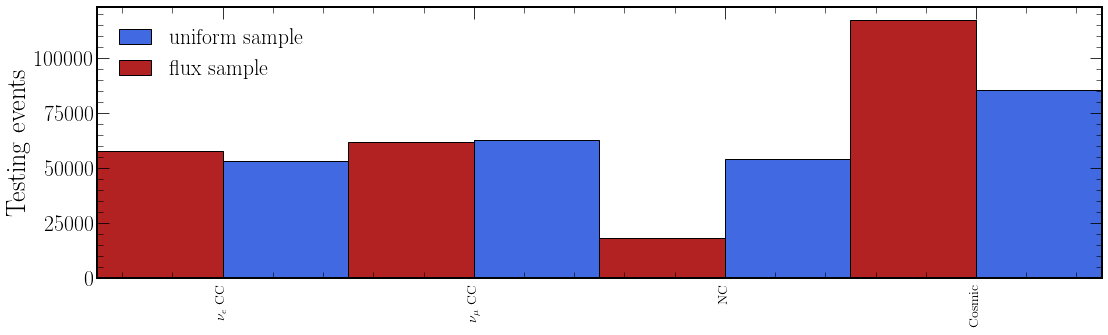

In [15]:
chipsnet.plotting.plot_cats(s_uniform_ev, s_flux_ev, chipsnet.data.MAP_FULL_COMB_CAT, save_path)

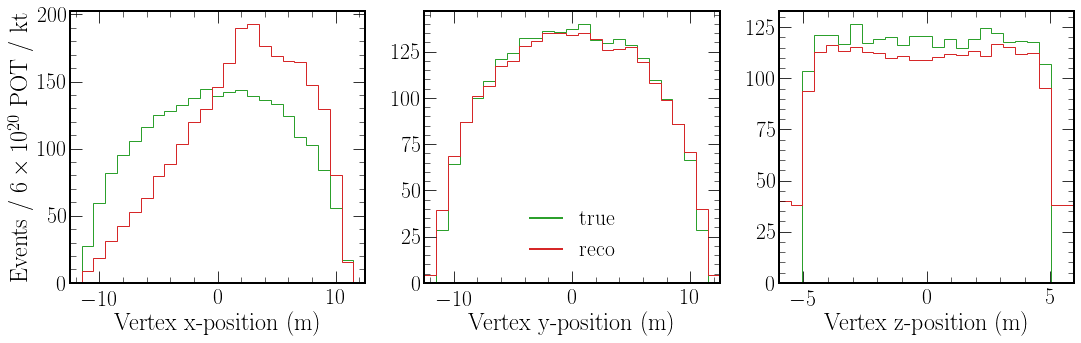

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
axs[0].hist(flux_ev[flux_ev["t_cosmic_cat"] == 0]["t_vtx_x"]/100, 
            range=(-12.5, 12.5), bins=25, color='tab:green', histtype='step', 
            weights=flux_ev[flux_ev["t_cosmic_cat"] == 0]["w"])
axs[0].hist(flux_ev[flux_ev["t_cosmic_cat"] == 0]["r_vtx_x"]*1250/100, 
            range=(-12.5, 12.5), bins=25, color='tab:red', histtype='step', 
            weights=flux_ev[flux_ev["t_cosmic_cat"] == 0]["w"])
axs[0].set_xlabel('Vertex x-position (m)', fontsize=24)
axs[0].set_ylabel(r"Events / $6\times10^{20}$ POT / kt", fontsize=24)
single = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label="true")
multi = Line2D([0], [0], color="tab:red", linewidth=2, linestyle="solid", label="reco")
axs[1].legend(handles=[single, multi], loc="lower center")

axs[1].hist(flux_ev[flux_ev["t_cosmic_cat"] == 0]["t_vtx_y"]/100,
            range=(-12.5, 12.5), bins=25, color='tab:green', histtype='step', 
            weights=flux_ev[flux_ev["t_cosmic_cat"] == 0]["w"])
axs[1].hist(flux_ev[flux_ev["t_cosmic_cat"] == 0]["r_vtx_y"]*1250/100, 
            range=(-12.5, 12.5), bins=25, color='tab:red', histtype='step', 
            weights=flux_ev[flux_ev["t_cosmic_cat"] == 0]["w"])
axs[1].set_xlabel('Vertex y-position (m)', fontsize=24)

axs[2].hist(flux_ev[flux_ev["t_cosmic_cat"] == 0]["t_vtx_z"]/100,
            range=(-6, 6), bins=25, color='tab:green', histtype='step', 
            weights=flux_ev[flux_ev["t_cosmic_cat"] == 0]["w"])
axs[2].hist(flux_ev[flux_ev["t_cosmic_cat"] == 0]["r_vtx_z"]*600/100, 
            range=(-6, 6), bins=25, color='tab:red', histtype='step', 
            weights=flux_ev[flux_ev["t_cosmic_cat"] == 0]["w"])
axs[2].set_xlabel('Vertex z-position (m)', fontsize=24)
chipsnet.plotting.save(save_path + "explore_vtx_positions")

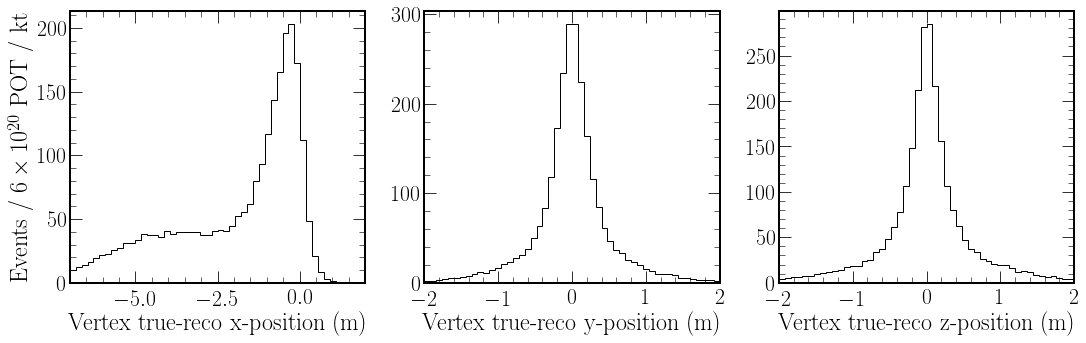

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
axs[0].hist(flux_ev[flux_ev["t_cosmic_cat"] == 0]["t_vtx_x"]/100-(flux_ev[flux_ev["t_cosmic_cat"] == 0]["r_vtx_x"]*1250/100),
            weights=flux_ev[flux_ev["t_cosmic_cat"] == 0]["w"], range=(-7, 2), bins=50, color='black', histtype='step')
axs[0].set_xlabel('Vertex true-reco x-position (m)', fontsize=24)
axs[0].set_ylabel(r"Events / $6\times10^{20}$ POT / kt", fontsize=24)

axs[1].hist(flux_ev[flux_ev["t_cosmic_cat"] == 0]["t_vtx_y"]/100-(flux_ev[flux_ev["t_cosmic_cat"] == 0]["r_vtx_y"]*1250/100),
            weights=flux_ev[flux_ev["t_cosmic_cat"] == 0]["w"], range=(-2, 2), bins=50, color='black', histtype='step')
axs[1].set_xlabel('Vertex true-reco y-position (m)', fontsize=24)

axs[2].hist(flux_ev[flux_ev["t_cosmic_cat"] == 0]["t_vtx_z"]/100-(flux_ev[flux_ev["t_cosmic_cat"] == 0]["r_vtx_z"]*600/100), 
            weights=flux_ev[flux_ev["t_cosmic_cat"] == 0]["w"], range=(-2, 2), bins=50, color='black', histtype='step')
axs[2].set_xlabel('Vertex true-reco z-position (m)', fontsize=24)
chipsnet.plotting.save(save_path + "explore_true_reco_vtx")

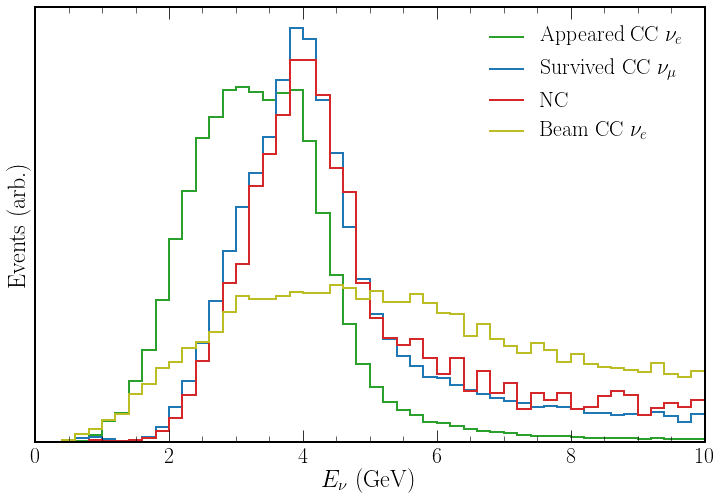

In [18]:
osc_nuel = matplotlib.lines.Line2D([], [], c='tab:green', linewidth=2)
numu = matplotlib.lines.Line2D([], [], c='tab:blue', linewidth=2)
nc = matplotlib.lines.Line2D([], [], c='tab:red', linewidth=2)
nuel = matplotlib.lines.Line2D([], [], c='tab:olive', linewidth=2)

fig, axs = plt.subplots(1, 1, figsize=(12, 8), gridspec_kw={'hspace': 0.3})
axs.hist(flux_ev[(flux_ev["t_comb_cat"] == 0) & (flux_ev["t_sample_type"] == 1)]["t_nu_energy"]/1000, 
         weights=flux_ev[(flux_ev["t_comb_cat"] == 0) & (flux_ev["t_sample_type"] == 1)]["w"],
         range=(0, 10), bins=50, color='tab:green', histtype='step', density=True, linewidth=2)
axs.hist(flux_ev[flux_ev["t_comb_cat"] == 1]["t_nu_energy"]/1000, weights=flux_ev[flux_ev["t_comb_cat"] == 1]["w"],
         range=(0, 10), bins=50, color='tab:blue', histtype='step', density=True, linewidth=2)
axs.hist(flux_ev[flux_ev["t_comb_cat"] == 2]["t_nu_energy"]/1000, weights=flux_ev[flux_ev["t_comb_cat"] == 2]["w"],
         range=(0, 10), bins=50, color='tab:red', histtype='step', density=True, linewidth=2)
axs.hist(flux_ev[(flux_ev["t_comb_cat"] == 0) & (flux_ev["t_sample_type"] == 0)]["t_nu_energy"]/1000, 
         weights=flux_ev[(flux_ev["t_comb_cat"] == 0) & (flux_ev["t_sample_type"] == 0)]["w"],
         range=(0, 10), bins=50, color='tab:olive', histtype='step', density=True, linewidth=2)
axs.legend(loc="upper right", handles=[osc_nuel, numu, nc, nuel], labels=[r"Appeared CC $\nu_{e}$", r"Survived CC $\nu_{\mu}$", r"NC", r"Beam CC $\nu_{e}$"])
axs.set_xlabel(r'$E_{\nu}$ (GeV)', fontsize=24)
axs.set_ylabel('Events (arb.)', fontsize=24)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
chipsnet.plotting.save(save_path + "explore_nu_energies")

In [19]:
# Setup an images dictionary to hold example images
image_size = [64, 64]
images_dict = {"r_charge_map_origin": [], "r_charge_map_iso": [], "r_charge_map_vtx": [],
               "r_time_map_origin": [], "r_time_map_iso": [], "r_time_map_vtx": [], "r_hough_map_vtx": []}
true_dict = {"t_code": [], "t_nu_energy": [], "t_lep_energy":[], "t_p_pdgs": [], "t_p_energies": [], "t_escapes": []}
               
# Load the images into the dictionary
nuel_file = uproot.open(nuel_map_file)
numu_file = uproot.open(numu_map_file)
cosmic_file = uproot.open(cosmic_map_file)
for image_name in images_dict.keys():
    images_dict[image_name].extend(nuel_file['reco'].array(image_name))
    images_dict[image_name].extend(numu_file['reco'].array(image_name))
    images_dict[image_name].extend(cosmic_file['reco'].array(image_name))
for truth_info in true_dict.keys():
    true_dict[truth_info].extend(nuel_file['true'].array(truth_info))
    true_dict[truth_info].extend(numu_file['true'].array(truth_info))
    true_dict[truth_info].extend(cosmic_file['true'].array(truth_info))    

# Calculate fraction of hits in the endcaps
cap_total = 0
barrel_total = 0
for event in images_dict['r_charge_map_vtx']:
    sections = np.split(event, [18, 46], axis=0)
    cap_total += (sections[0].sum() + sections[2].sum())
    barrel_total += sections[1].sum()

# This is with cosmic events included
print("Fraction of deposited charge in endcaps = {}".format(cap_total/(cap_total+barrel_total)))

Fraction of deposited charge in endcaps = 0.4769380479133997


3
3307.41
2777.48
[  11 2212 2212  111 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999
 -999 -999 -999 -999 -999 -999]
[2777.48  1085.32   991.703  318.527 -999.    -999.    -999.    -999.
 -999.    -999.    -999.    -999.    -999.    -999.    -999.    -999.
 -999.    -999.    -999.    -999.   ]
0


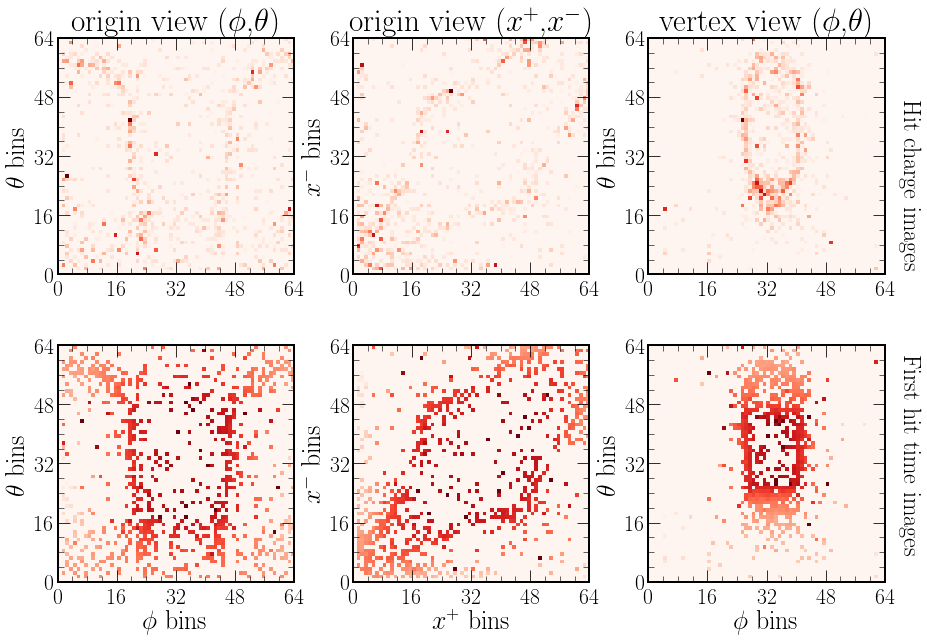

In [20]:
event_num = 1009
print(true_dict["t_code"][event_num])
print(true_dict["t_nu_energy"][event_num])
print(true_dict["t_lep_energy"][event_num])
print(true_dict["t_p_pdgs"][event_num])
print(true_dict["t_p_energies"][event_num])
print(true_dict["t_escapes"][event_num])
chipsnet.plotting.plot_hit_time(images_dict, event_num, save_path+"explore_nuel_ccres_event")

91
3520.17
1862.55
[2212   13 2112  211  211   22 -999 -999 -999 -999 -999 -999 -999 -999
 -999 -999 -999 -999 -999 -999]
[2022.37  1862.55  1038.34   226.973  223.71     6.32  -999.    -999.
 -999.    -999.    -999.    -999.    -999.    -999.    -999.    -999.
 -999.    -999.    -999.    -999.   ]
0


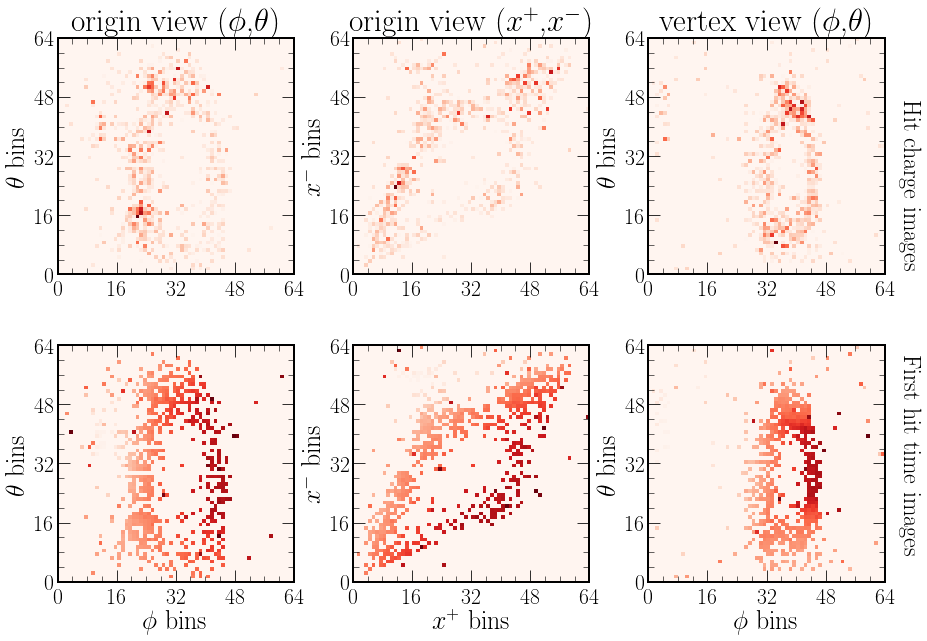

In [21]:
event_num = 2014

print(true_dict["t_code"][event_num])
print(true_dict["t_nu_energy"][event_num])
print(true_dict["t_lep_energy"][event_num])
print(true_dict["t_p_pdgs"][event_num])
print(true_dict["t_p_energies"][event_num])
print(true_dict["t_escapes"][event_num])
chipsnet.plotting.plot_hit_time(images_dict, event_num, save_path+"explore_numu_ccdis_event")

100
2928.5
2928.5
[  13 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999
 -999 -999 -999 -999 -999 -999]
[2928.5 -999.  -999.  -999.  -999.  -999.  -999.  -999.  -999.  -999.
 -999.  -999.  -999.  -999.  -999.  -999.  -999.  -999.  -999.  -999. ]
0


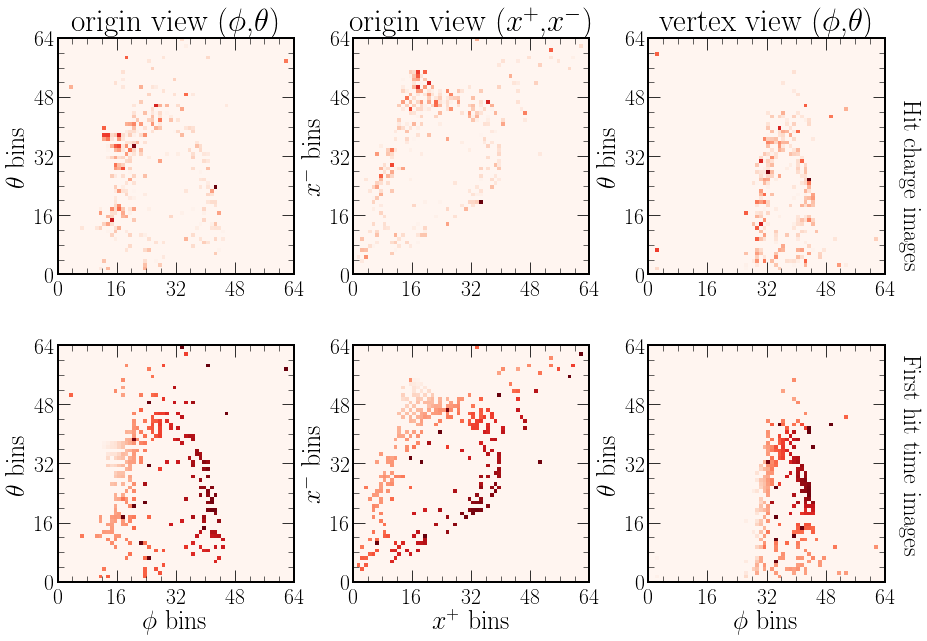

In [22]:
event_num = 4006
print(true_dict["t_code"][event_num])
print(true_dict["t_nu_energy"][event_num])
print(true_dict["t_lep_energy"][event_num])
print(true_dict["t_p_pdgs"][event_num])
print(true_dict["t_p_energies"][event_num])
print(true_dict["t_escapes"][event_num])
chipsnet.plotting.plot_hit_time(images_dict, event_num, save_path+"explore_cosmic_event")

92
9301.59
-1.0
[  12 2212  211 2212 2212 2112 -999 -999 -999 -999 -999 -999 -999 -999
 -999 -999 -999 -999 -999 -999]
[4731.25  2635.15  2511.54  1046.97   998.676  993.868 -999.    -999.
 -999.    -999.    -999.    -999.    -999.    -999.    -999.    -999.
 -999.    -999.    -999.    -999.   ]
-1


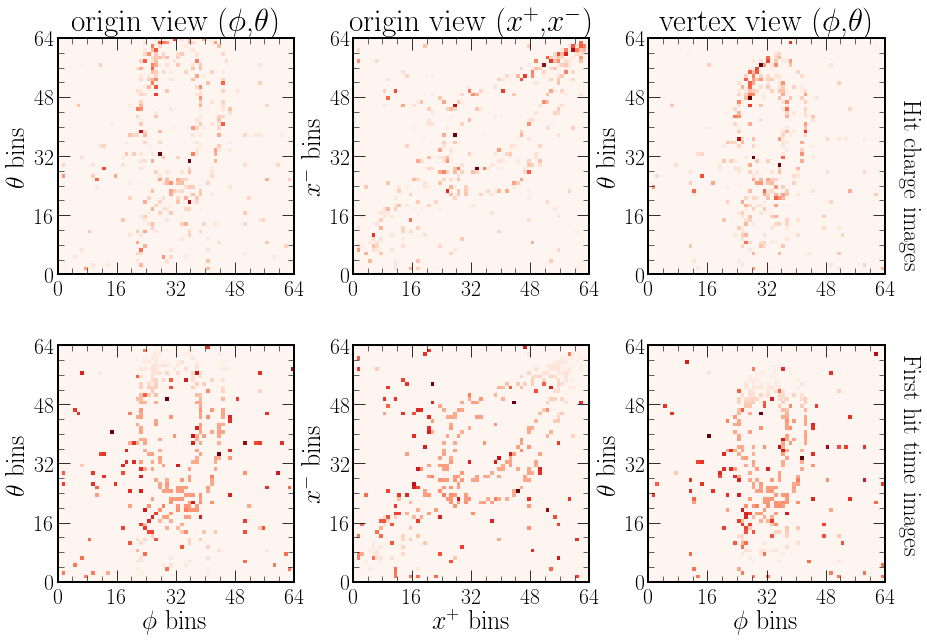

In [23]:
event_num = 1045
print(true_dict["t_code"][event_num])
print(true_dict["t_nu_energy"][event_num])
print(true_dict["t_lep_energy"][event_num])
print(true_dict["t_p_pdgs"][event_num])
print(true_dict["t_p_energies"][event_num])
print(true_dict["t_escapes"][event_num])
chipsnet.plotting.plot_hit_time(images_dict, event_num, save_path+"explore_nuel_ncdis_event")

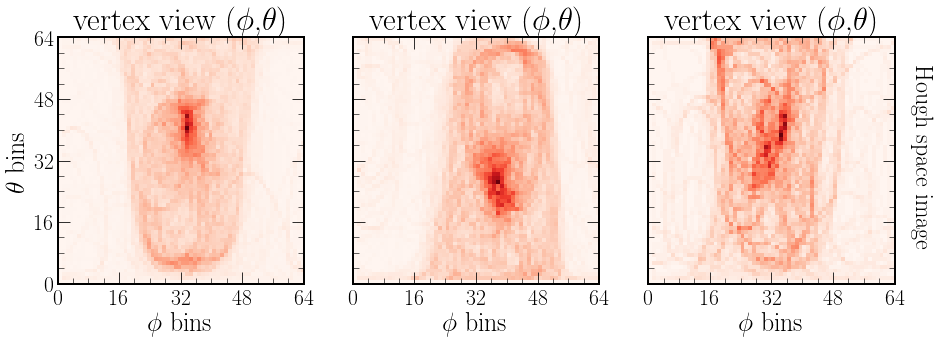

In [24]:
chipsnet.plotting.plot_hough(images_dict, [1009, 2014, 1045], save_path+"explore_hough_events")

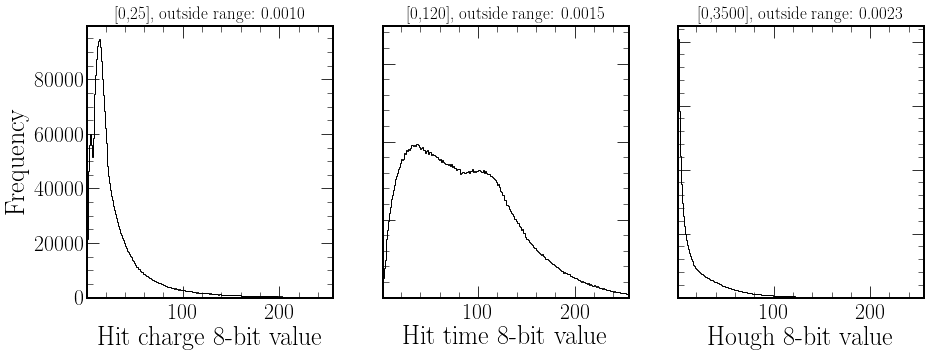

In [25]:
chipsnet.plotting.plot_8bit_range(images_dict, save_path=save_path)

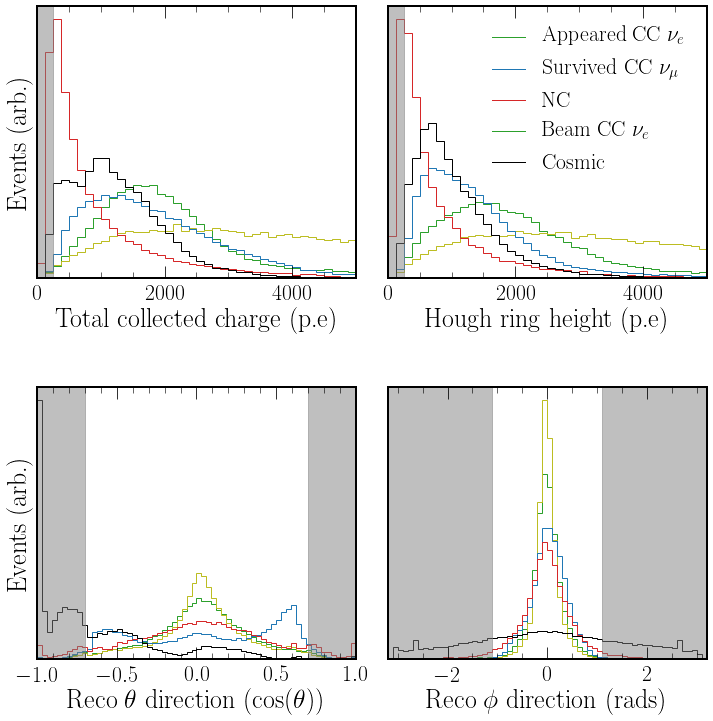

In [26]:
chipsnet.plotting.plot_cuts(config, flux_ev, save_path)

In [27]:
# Tidy up
del s_both_ev, s_both_out
del s_flux_ev, s_flux_out
del s_uniform_ev, s_uniform_out
del flux_ev, flux_out
del images_dict
del numu_ev, nuel_ev, osc_nuel_ev

<a id='sample'></a>

## Which training sample is best? (sample)
* The training sample used has a significant impact on performance.
* This is due to both the ratio of the different number of events and the energy distribution of them
* Using the expected beam flux as expected has the best performance for then evaluating the beam flux

In [4]:
ev, outputs = chipsnet.utils.evaluate(
    config, 
    "flux", 
    ["sample_both", "sample_flux", "sample_uniform"],
    ["t_all_cat", "t_all_cat", "t_all_cat"]
)


************************ Evaluating flux ************************
Loading best checkpoint (7)
Loading best checkpoint (6)
Loading best checkpoint (6)
Weights: (65944,0.00059), (15850,0.00016), (40826,0.08213), (82311,0.00089), (0,0.00000)
Cuts:    (108251,0.95368), (99108,0.93510), (25236,0.69130), (0,0.00000)

------------------------ sample_both report ------------------------
- Comb-> Prec: (0.93827,0.69684), Rec: (0.90195,0.86222), F1: (0.91509,0.73729)
- Cat->  Prec: (0.57792,0.33143), Rec: (0.48673,0.42725), F1: (0.50108,0.30223)

- Nuel-> ROC-AUC: 0.81761, PRC-AUC: 0.63804, S-Eff: 0.83072, S-Pur: 0.37025
- FOM1-> 0.38743, 0.85000, 51.50949, 18.09410, 16.79612, 0.64986, 0.59618
- FOM2-> 10.61501, 0.95500, 32.40572, 4.67263, 4.64708, 0.40884, 0.77664

- Numu-> ROC-AUC: 0.66463, PRC-AUC: 0.91918, S-Eff: 0.85148, S-Pur: 0.99284
- FOM1-> 0.86707, 0.09000, 4.85300, 1830.99719, 56.72668, 0.89623, 0.96746
- FOM2-> 2756.15847, 0.99500, 0.02892, 1405.68326, 0.23119, 0.68805, 0.99981


--

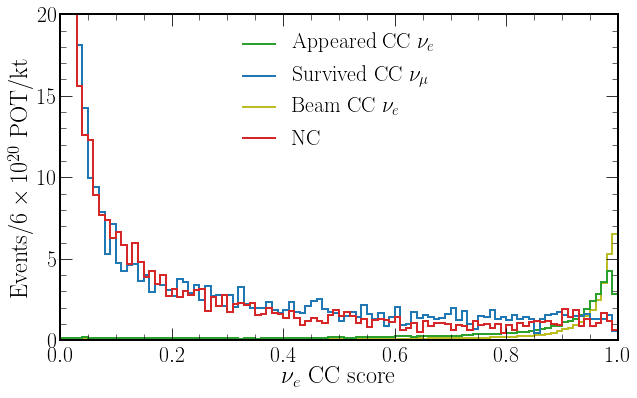

In [5]:
chipsnet.plotting.plot_combined_values(ev, 0, "sample_both_", save_path+"sample_both_output_values")

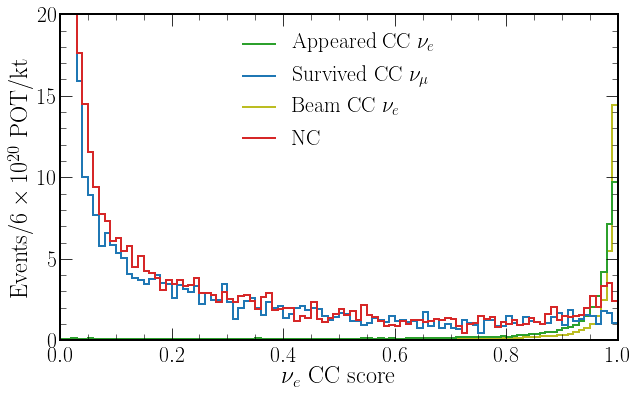

In [6]:
chipsnet.plotting.plot_combined_values(ev, 0, "sample_flux_", save_path+"sample_flux_output_values")

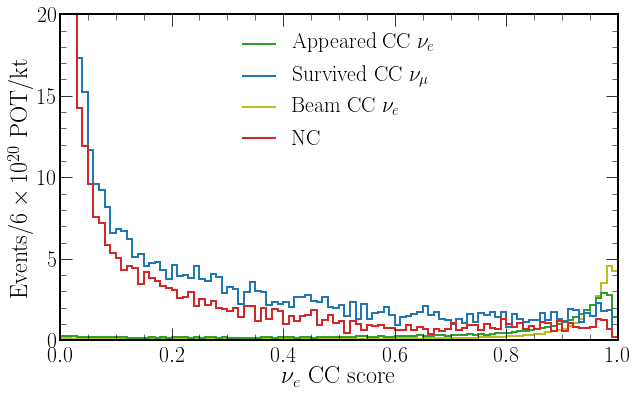

In [7]:
chipsnet.plotting.plot_combined_values(ev, 0, "sample_uniform_", save_path+"sample_uniform_output_values")

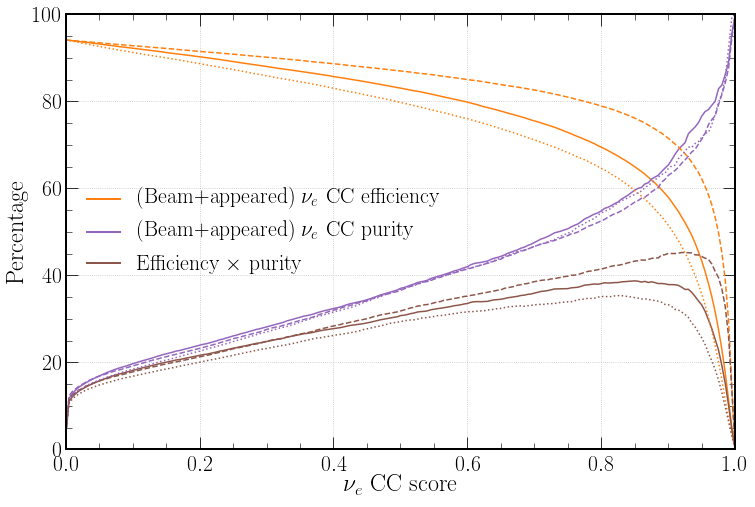

In [8]:
chipsnet.plotting.plot_eff_curves([outputs[0], outputs[1], outputs[2]], 0, save_path+"sample_nuel_eff_curves")

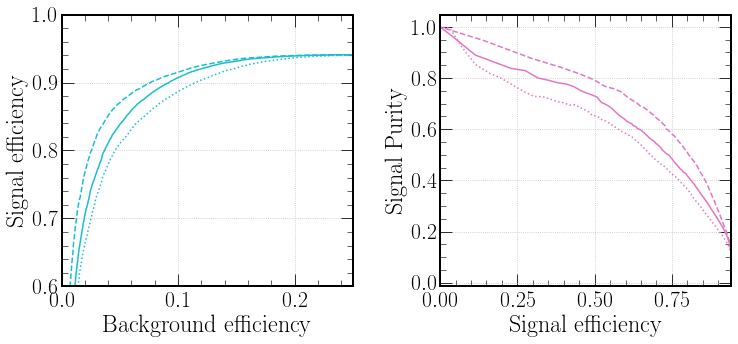

In [9]:
chipsnet.plotting.plot_comp_curves([outputs[0], outputs[1], outputs[2]], 0, save_path+"sample_nuel_comp_curves")

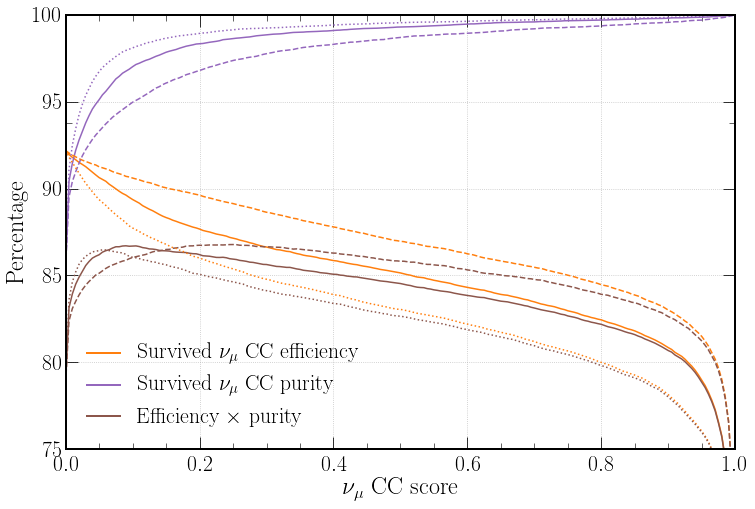

In [10]:
chipsnet.plotting.plot_eff_curves([outputs[0], outputs[1], outputs[2]], 1, save_path+"sample_numu_eff_curves")

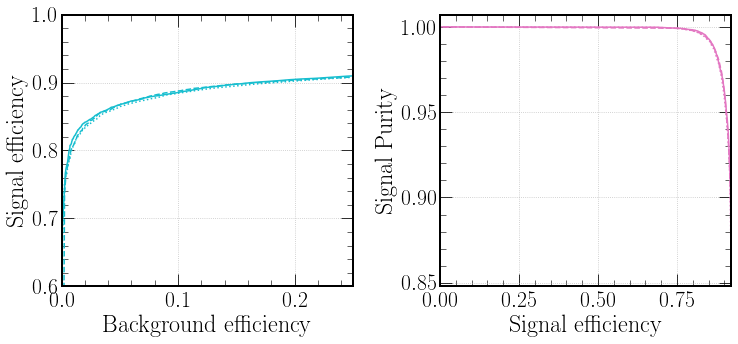

In [11]:
chipsnet.plotting.plot_comp_curves([outputs[0], outputs[1], outputs[2]], 1, save_path+"sample_numu_comp_curves")

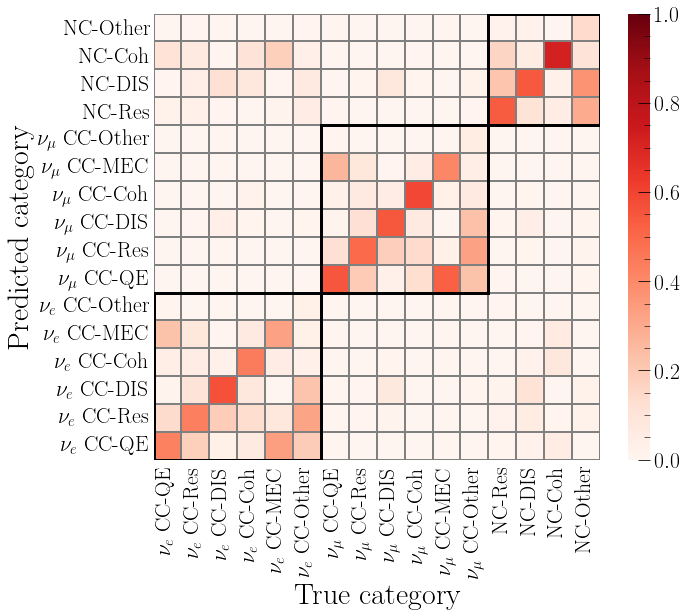

In [12]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(
    outputs[0]["cat_matrix"],
    annot=False, 
    vmin=0.0, 
    vmax=1.0,
    xticklabels=chipsnet.data.MAP_ALL_CAT["labels"][:16],
    yticklabels=chipsnet.data.MAP_ALL_CAT["labels"][:16][::-1],
    cbar=True,
    cbar_kws={"shrink": .82},
    square=True,
    linewidth=1,
    linecolor="grey",
    cmap="Reds")
axs.tick_params(axis='both', which='both',
                bottom=False, top=False, left=False, right=False)
axs.set_xlabel('True category', fontsize = 30)
axs.set_ylabel('Predicted category', fontsize = 30)
axs.add_patch(patches.Rectangle((0, 10), 6, 6, linewidth=3, edgecolor='black', facecolor='none'))
axs.add_patch(patches.Rectangle((6, 4), 6, 6, linewidth=3, edgecolor='black', facecolor='none'))
axs.add_patch(patches.Rectangle((12, 0), 4, 4, linewidth=3, edgecolor='black', facecolor='none'))
chipsnet.plotting.save(save_path + "sample_both_matrix")

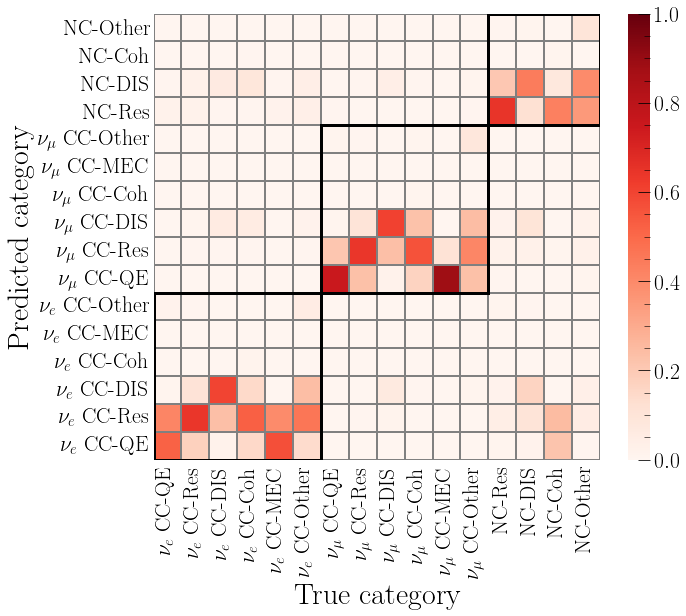

In [13]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(
    outputs[1]["cat_matrix"],
    annot=False, 
    vmin=0.0, 
    vmax=1.0,
    xticklabels=chipsnet.data.MAP_ALL_CAT["labels"][:16],
    yticklabels=chipsnet.data.MAP_ALL_CAT["labels"][:16][::-1],
    cbar=True,
    cbar_kws={"shrink": .82},
    square=True,
    linewidth=1,
    linecolor="grey",
    cmap="Reds")
axs.tick_params(axis='both', which='both',
                bottom=False, top=False, left=False, right=False)
axs.set_xlabel('True category', fontsize = 30)
axs.set_ylabel('Predicted category', fontsize = 30)
axs.add_patch(patches.Rectangle((0, 10), 6, 6, linewidth=3, edgecolor='black', facecolor='none'))
axs.add_patch(patches.Rectangle((6, 4), 6, 6, linewidth=3, edgecolor='black', facecolor='none'))
axs.add_patch(patches.Rectangle((12, 0), 4, 4, linewidth=3, edgecolor='black', facecolor='none'))
chipsnet.plotting.save(save_path + "sample_flux_matrix")

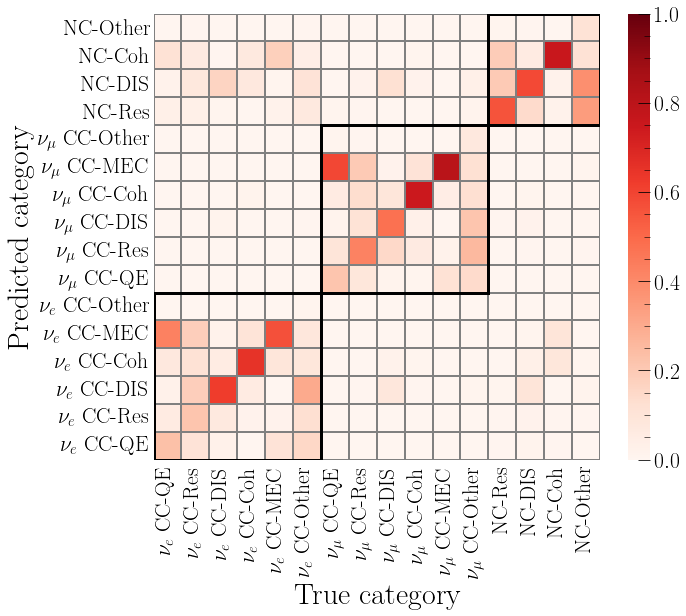

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(
    outputs[2]["cat_matrix"],
    annot=False, 
    vmin=0.0, 
    vmax=1.0,
    xticklabels=chipsnet.data.MAP_ALL_CAT["labels"][:16],
    yticklabels=chipsnet.data.MAP_ALL_CAT["labels"][:16][::-1],
    cbar=True,
    cbar_kws={"shrink": .82},
    square=True,
    linewidth=1,
    linecolor="grey",
    cmap="Reds")
axs.tick_params(axis='both', which='both',
                bottom=False, top=False, left=False, right=False)
axs.set_xlabel('True category', fontsize = 30)
axs.set_ylabel('Predicted category', fontsize = 30)
axs.add_patch(patches.Rectangle((0, 10), 6, 6, linewidth=3, edgecolor='black', facecolor='none'))
axs.add_patch(patches.Rectangle((6, 4), 6, 6, linewidth=3, edgecolor='black', facecolor='none'))
axs.add_patch(patches.Rectangle((12, 0), 4, 4, linewidth=3, edgecolor='black', facecolor='none'))
chipsnet.plotting.save(save_path + "sample_uniform_matrix")

In [15]:
# Tidy up
del outputs

<a id='repr'></a>

## Which image representation is best? (repr)
* The theta/phi representation as viewed from the roughly reconstructed interaction vertex is clearly the best
* It performs better on every performance metric
* This is definitely due to the way it standardises the input events, so they are scaled/viewed correctly and the different shapes can more easily be identified.

In [16]:
v_out = chipsnet.utils.evaluate(config, "v_ct_flux", ["repr_v_ct"], ["t_all_cat"], just_out=True)  # Vertex theta/phi repr
o_out = chipsnet.utils.evaluate(config, "o_ct_flux", ["repr_o_ct"], ["t_all_cat"], just_out=True)  # Origin theta/phi repr
i_out = chipsnet.utils.evaluate(config, "i_ct_flux", ["repr_i_ct"], ["t_all_cat"], just_out=True)  # Origin x+/x- repr


************************ Evaluating v_ct_flux ************************
Loading best checkpoint (6)
Weights: (65944,0.00059), (12521,0.00020), (42717,0.07850), (79661,0.00092), (0,0.00000)
Cuts:    (108814,0.95265), (98424,0.93411), (25129,0.69017), (0,0.00000)

------------------------ repr_v_ct report ------------------------
- Comb-> Prec: (0.94213,0.71425), Rec: (0.90374,0.84628), F1: (0.91631,0.72624)
- Cat->  Prec: (0.57295,0.33186), Rec: (0.55202,0.31954), F1: (0.53449,0.27031)

- Nuel-> ROC-AUC: 0.82072, PRC-AUC: 0.69262, S-Eff: 0.87207, S-Pur: 0.35019
- FOM1-> 0.44487, 0.94000, 50.88758, 8.11695, 14.49015, 0.64251, 0.69240
- FOM2-> 12.67370, 0.98500, 29.60216, 1.99294, 3.46263, 0.37376, 0.84438

- Numu-> ROC-AUC: 0.66346, PRC-AUC: 0.91840, S-Eff: 0.86700, S-Pur: 0.98703
- FOM1-> 0.86543, 0.20500, 3.76729, 1820.85528, 49.51396, 0.89076, 0.97157
- FOM2-> 1420.98810, 0.99500, 0.03639, 1478.57950, 1.04632, 0.72332, 0.99927

took 296.36 seconds

************************ Evaluating 

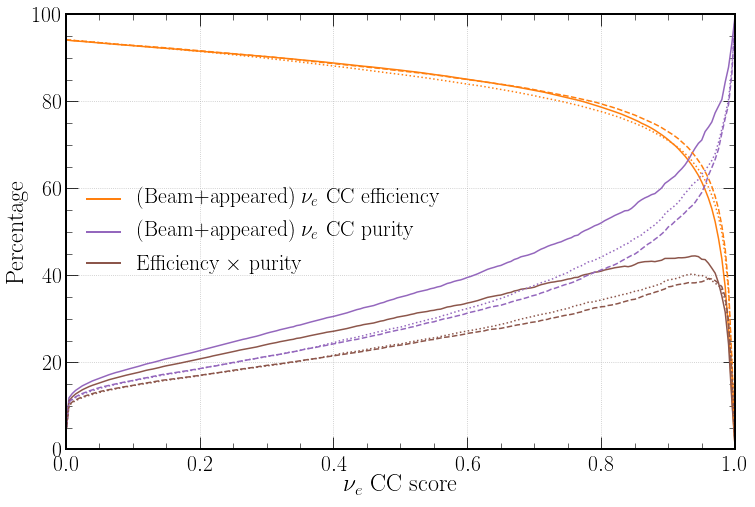

In [17]:
chipsnet.plotting.plot_eff_curves([v_out[0], o_out[0], i_out[0]], 0, save_path+"repr_nuel_eff_curves")

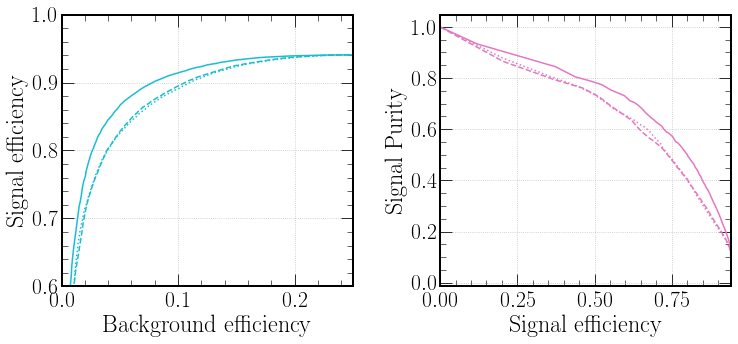

In [18]:
chipsnet.plotting.plot_comp_curves([v_out[0], o_out[0], i_out[0]], 0, save_path+"repr_nuel_comp_curves")

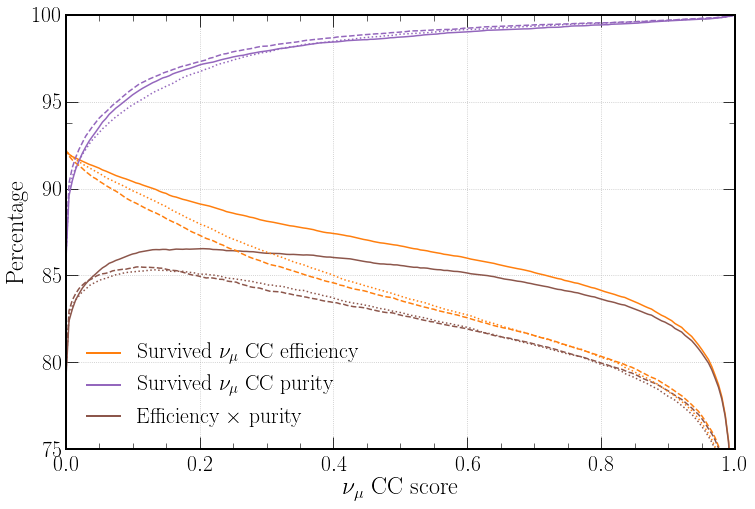

In [19]:
chipsnet.plotting.plot_eff_curves([v_out[0], o_out[0], i_out[0]], 1, save_path+"repr_numu_eff_curves")

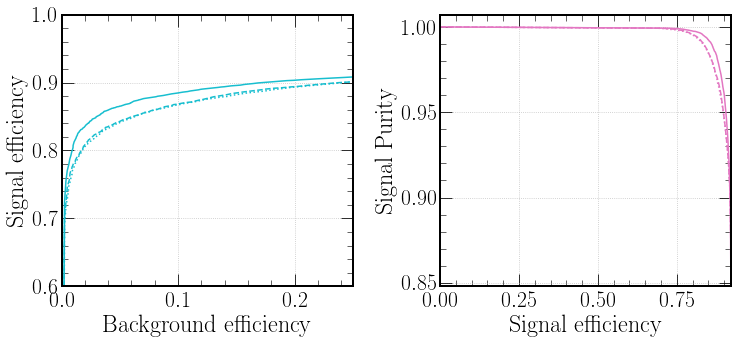

In [20]:
chipsnet.plotting.plot_comp_curves([v_out[0], o_out[0], i_out[0]], 1, save_path+"repr_numu_comp_curves")

In [21]:
# Tidy up
del v_out
del o_out
del i_out

<a id='channel'></a>

## Which channel configuration is best? (channel)
* The differences are much smaller than you would expect given the extra info you would think the extra channels provide
* Overall having all three channels together does make a difference
* It also is much better to have the seperate stems for each channel rather than using a single 3 channel image

In [22]:
c_out = chipsnet.utils.evaluate(config, "v_c_flux", ["repr_v_c"], ["t_all_cat"], just_out=True)  # Just charge channel
ct_out = chipsnet.utils.evaluate(config, "v_ct_flux", ["repr_v_ct"], ["t_all_cat"], just_out=True)  # Charge+time channels
cth_out = chipsnet.utils.evaluate(config,"v_cth_flux", ["repr_v_cth"], ["t_all_cat"], just_out=True)  # Charge+time+hough channels
cth_stacked_out = chipsnet.utils.evaluate(config, "v_cth_flux_stacked", ["repr_v_cth_stacked"], ["t_all_cat"], just_out=True)  # Charge+time+hough channels stacked


************************ Evaluating v_c_flux ************************
Loading best checkpoint (7)
Weights: (65944,0.00059), (10714,0.00024), (42717,0.07850), (79563,0.00092), (0,0.00000)
Cuts:    (108873,0.95219), (98356,0.93402), (25051,0.68903), (0,0.00000)

------------------------ repr_v_c report ------------------------
- Comb-> Prec: (0.93845,0.70387), Rec: (0.89982,0.84363), F1: (0.91300,0.72163)
- Cat->  Prec: (0.56440,0.33086), Rec: (0.53616,0.31047), F1: (0.51854,0.26381)

- Nuel-> ROC-AUC: 0.81874, PRC-AUC: 0.67004, S-Eff: 0.86090, S-Pur: 0.34400
- FOM1-> 0.41371, 0.93000, 50.57741, 11.73384, 15.77592, 0.63873, 0.64770
- FOM2-> 13.50570, 0.99500, 9.35441, 0.00769, 0.47204, 0.11813, 0.95122

- Numu-> ROC-AUC: 0.66142, PRC-AUC: 0.91796, S-Eff: 0.86194, S-Pur: 0.98735
- FOM1-> 0.86045, 0.17500, 4.16805, 1818.05460, 56.94213, 0.88938, 0.96748
- FOM2-> 1308.17924, 0.99500, 0.05748, 1505.55660, 1.26705, 0.73650, 0.99912

took 203.02 seconds

************************ Evaluating v_

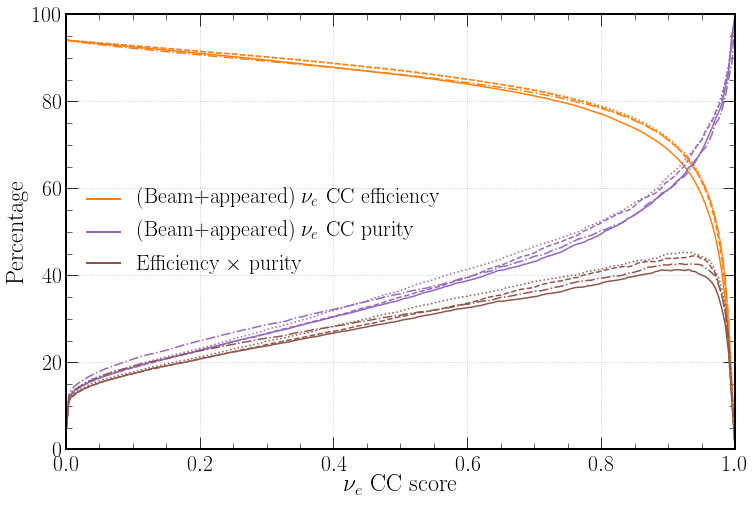

In [23]:
chipsnet.plotting.plot_eff_curves([c_out[0], ct_out[0], cth_out[0], cth_stacked_out[0]], 0, save_path+"channel_nuel_eff_curves")

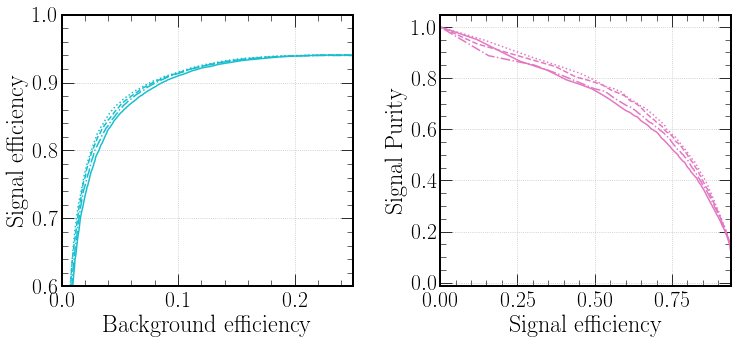

In [24]:
chipsnet.plotting.plot_comp_curves([c_out[0], ct_out[0], cth_out[0], cth_stacked_out[0]], 0, save_path+"channel_nuel_comp_curves")

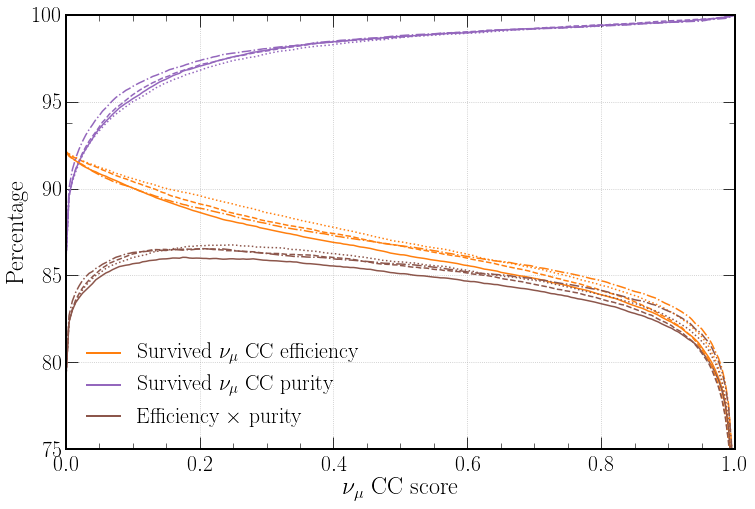

In [25]:
chipsnet.plotting.plot_eff_curves([c_out[0], ct_out[0], cth_out[0], cth_stacked_out[0]], 1, save_path+"channel_numu_eff_curves")

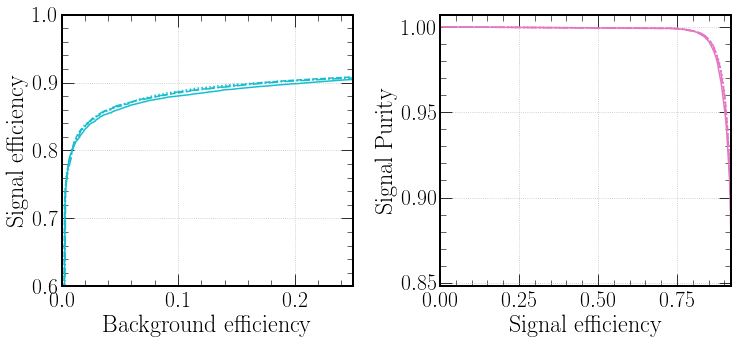

In [26]:
chipsnet.plotting.plot_comp_curves([c_out[0], ct_out[0], cth_out[0], cth_stacked_out[0]], 1, save_path+"channel_numu_comp_curves")

In [27]:
# Tidy up
del c_out
del ct_out
del cth_out
del cth_stacked_out

<a id='cat'></a>

## Which categorisation is best? (cat)
* It looks like the split learner using ["t_comb_cat", "t_cc_type", "t_nc_type"] is the best, but by an almost negligble difference
* Still need to look at how well it splits apart to cc and nc types for full analysis
* A close second is then "t_all_cat" this is still reasonable to use to simplify other studies

In [28]:
outputs = chipsnet.utils.evaluate(
    config, 
    "flux", 
    ["cat_t_all_cat", "cat_t_nc_comb_cat", "cat_t_comb_cat", "cat_split", "cat_split_learn"], 
    ["t_all_cat", "t_nc_comb_cat", "t_comb_cat", "t_comb_cat", "t_comb_cat"],
    just_out=True
)


************************ Evaluating flux ************************
Loading best checkpoint (6)
Loading best checkpoint (7)
Loading best checkpoint (5)
Loading best checkpoint (6)
Loading best checkpoint (6)
Weights: (65944,0.00059), (14507,0.00017), (42717,0.07850), (80750,0.00091), (0,0.00000)
Cuts:    (107936,0.95316), (99323,0.93430), (25179,0.69073), (0,0.00000)

------------------------ cat_t_all_cat report ------------------------
- Comb-> Prec: (0.94138,0.71738), Rec: (0.90623,0.84700), F1: (0.91754,0.73091)
- Cat->  Prec: (0.57105,0.32941), Rec: (0.55490,0.32072), F1: (0.53592,0.27212)

- Nuel-> ROC-AUC: 0.82115, PRC-AUC: 0.70330, S-Eff: 0.87034, S-Pur: 0.36520
- FOM1-> 0.45258, 0.92000, 54.48699, 10.00456, 18.32040, 0.68785, 0.65796
- FOM2-> 14.40917, 0.99500, 11.18240, 0.25147, 0.35080, 0.14117, 0.94889

- Numu-> ROC-AUC: 0.66356, PRC-AUC: 0.91842, S-Eff: 0.86927, S-Pur: 0.98673
- FOM1-> 0.86757, 0.24500, 3.55546, 1822.56622, 46.89532, 0.89159, 0.97306
- FOM2-> 1351.81719, 0.

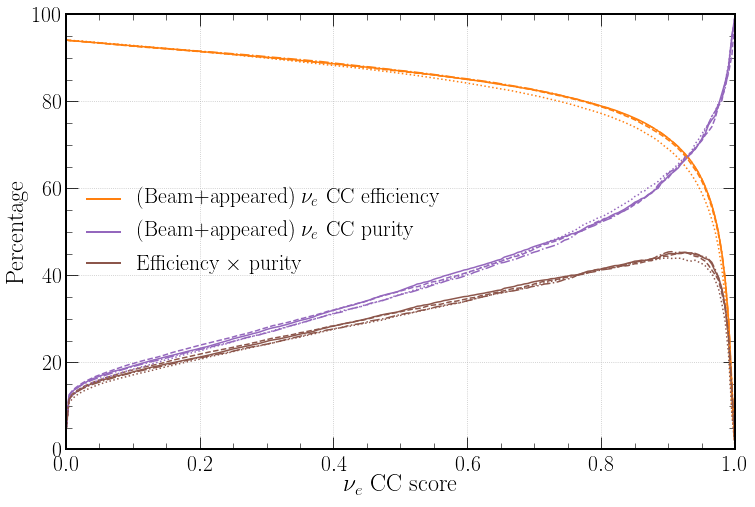

In [29]:
chipsnet.plotting.plot_eff_curves([outputs[0], outputs[1], outputs[2], outputs[3]], 0, save_path+"cat_nuel_eff_curves")

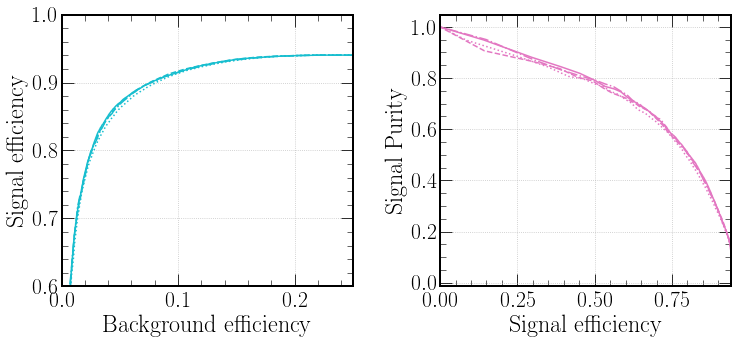

In [30]:
chipsnet.plotting.plot_comp_curves([outputs[0], outputs[1], outputs[2], outputs[3]], 0, save_path+"cat_nuel_comp_curves")

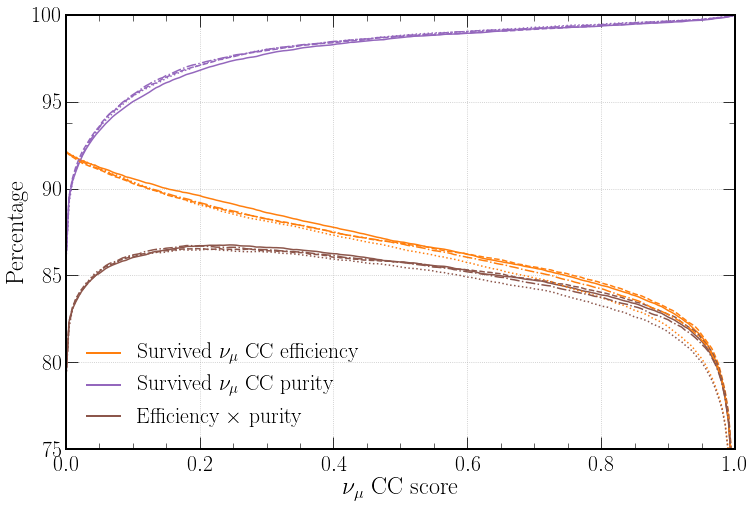

In [31]:
chipsnet.plotting.plot_eff_curves([outputs[0], outputs[1], outputs[2], outputs[3]], 1, save_path+"cat_numu_eff_curves")

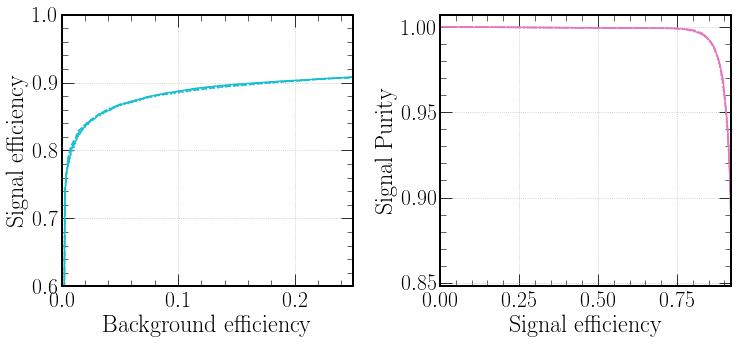

In [32]:
chipsnet.plotting.plot_comp_curves([outputs[0], outputs[1], outputs[2], outputs[3]], 1, save_path+"cat_numu_comp_curves")

In [33]:
# Tidy up
del outputs

<a id='cosmic'></a>

## Does escapes help cosmic classifier? (cosmic)
* Looks like the single t_cosmic_cat classifier and the learned + t_escapes are the best
* Looks like the events that do pass are mainly classified as NC which is good
* Need to do a final evaluation with the complete final beam model to make sure

In [34]:
ev, out = chipsnet.utils.evaluate(config, "cosmic", ["repr_v_cth", "cosmic"], ["t_all_cat", "t_cosmic_cat"], just_cosmic=True)
ev_e, out_e = chipsnet.utils.evaluate(config, "cosmic", ["repr_v_cth", "cosmic_escapes"], ["t_all_cat", "t_cosmic_cat"], just_cosmic=True)
ev_el, out_el = chipsnet.utils.evaluate(config, "cosmic", ["repr_v_cth", "cosmic_escapes_learn"], ["t_all_cat", "t_cosmic_cat"], just_cosmic=True)


************************ Evaluating cosmic ************************
Loading best checkpoint (6)
Loading best checkpoint (6)
Weights: (0,0.00000), (0,0.00000), (0,0.00000), (0,0.00000), (256000,4.72929)
count    2.560000e+05
mean     9.992455e-01
std      1.957438e-02
min      2.461697e-10
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: cosmic_pred_t_cosmic_cat, dtype: float64
Cuts:    (0,0.00000), (0,0.00000), (0,0.00000), (6,0.00002)
took 641.29 seconds

************************ Evaluating cosmic ************************
Loading best checkpoint (6)
Loading best checkpoint (3)
Weights: (0,0.00000), (0,0.00000), (0,0.00000), (0,0.00000), (256000,4.72929)
count    256000.000000
mean          0.998900
std           0.020934
min           0.000141
25%           0.999990
50%           0.999999
75%           1.000000
max           1.000000
Name: cosmic_escapes_pred_t_cosmic_cat, dtype: float64
Cuts:    (0,0.00000), (0,0.00000), (0,0.00000), (2,0

In [35]:
print(ev[ev["cut"] == 0]["repr_v_cth_pred_t_comb_cat_0"].to_numpy())
print(ev[ev["cut"] == 0]["repr_v_cth_pred_t_comb_cat_1"].to_numpy())
print(ev[ev["cut"] == 0]["repr_v_cth_pred_t_comb_cat_2"].to_numpy())
print(ev[ev["cut"] == 0]["repr_v_cth_comb_cat_class"].to_numpy())

[2.76360112e-01 1.28841776e-02 1.61161209e-06 6.20149654e-02
 9.24002625e-01 2.24383163e-05]
[0.12627261 0.88345136 0.99998431 0.01431722 0.00582996 0.99948725]
[5.97367311e-01 1.03664412e-01 1.40568721e-05 9.23667832e-01
 7.01674442e-02 4.90394243e-04]
[2 1 1 2 0 1]


In [36]:
print(ev_e[ev_e["cut"] == 0]["repr_v_cth_pred_t_comb_cat_0"].to_numpy())
print(ev_e[ev_e["cut"] == 0]["repr_v_cth_pred_t_comb_cat_1"].to_numpy())
print(ev_e[ev_e["cut"] == 0]["repr_v_cth_pred_t_comb_cat_2"].to_numpy())
print(ev_e[ev_e["cut"] == 0]["repr_v_cth_comb_cat_class"].to_numpy())

[0.27636011 0.03567247]
[0.12627261 0.04241122]
[0.59736731 0.92191629]
[2 2]


In [37]:
print(ev_el[ev_el["cut"] == 0]["repr_v_cth_pred_t_comb_cat_0"].to_numpy())
print(ev_el[ev_el["cut"] == 0]["repr_v_cth_pred_t_comb_cat_1"].to_numpy())
print(ev_el[ev_el["cut"] == 0]["repr_v_cth_pred_t_comb_cat_2"].to_numpy())
print(ev_el[ev_el["cut"] == 0]["repr_v_cth_comb_cat_class"].to_numpy())

[2.76360112e-01 1.61161209e-06 6.20149654e-02]
[0.12627261 0.99998431 0.01431722]
[5.97367311e-01 1.40568721e-05 9.23667832e-01]
[2 1 2]


In [38]:
# Tidy up
del ev, out
del ev_e, out_e
del ev_el, out_el

<a id='beam'></a>

## Does primary count help beam classifier? (beam)
* Yes it does help, not a huge effect but it definitely add something, which makes sense.
* The "learned" version of the multitask weights seems to work best.
* Still need to combine with the correct category type to see if that has a different effect.

In [39]:
outputs = chipsnet.utils.evaluate(
    config, 
    "flux", 
    ["beam", "beam_primaries", "beam_primaries_learn"],
    ["t_comb_cat", "t_comb_cat", "t_comb_cat"],
    just_out=True
)


************************ Evaluating flux ************************
Loading best checkpoint (6)
Loading best checkpoint (6)
Loading best checkpoint (4)
Weights: (65944,0.00059), (10699,0.00024), (42717,0.07850), (79563,0.00092), (0,0.00000)
Cuts:    (108869,0.95220), (98357,0.93401), (25049,0.68892), (0,0.00000)

------------------------ beam report ------------------------
- Comb-> Prec: (0.94299,0.71739), Rec: (0.90643,0.85057), F1: (0.91845,0.73209)
- Cat->  Prec: (0.94299,0.71739), Rec: (0.90643,0.85057), F1: (0.91845,0.73209)

- Nuel-> ROC-AUC: 0.82108, PRC-AUC: 0.70221, S-Eff: 0.87128, S-Pur: 0.35581
- FOM1-> 0.45488, 0.90500, 56.22098, 12.74424, 18.79552, 0.71006, 0.64062
- FOM2-> 15.09211, 0.99500, 11.83716, 0.34642, 0.26875, 0.14950, 0.95060

- Numu-> ROC-AUC: 0.66339, PRC-AUC: 0.91840, S-Eff: 0.86827, S-Pur: 0.98770
- FOM1-> 0.86723, 0.18500, 3.77868, 1826.80899, 51.88207, 0.89366, 0.97043
- FOM2-> 1333.16850, 0.99500, 0.04830, 1513.18636, 1.23999, 0.74024, 0.99915


---------

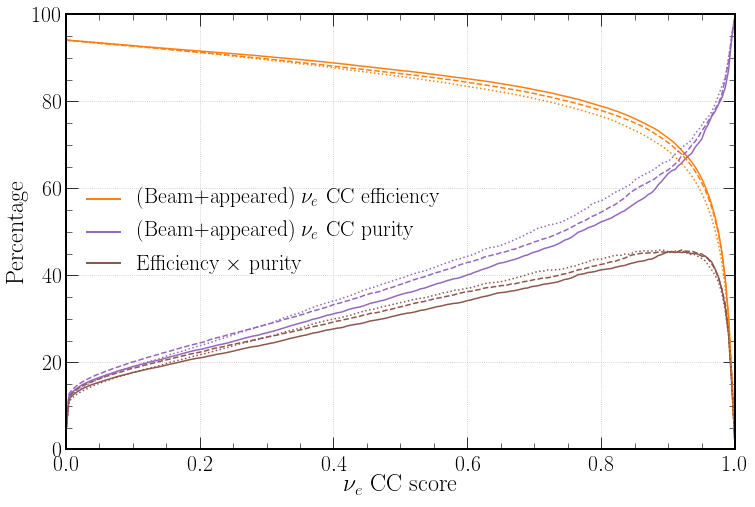

In [40]:
chipsnet.plotting.plot_eff_curves([outputs[0], outputs[1], outputs[2]], 0, save_path+"beam_nuel_eff_curves")

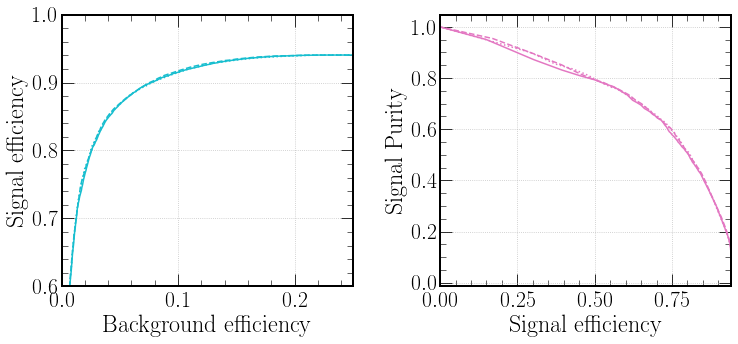

In [41]:
chipsnet.plotting.plot_comp_curves([outputs[0], outputs[1], outputs[2]], 0, save_path+"beam_nuel_comp_curves")

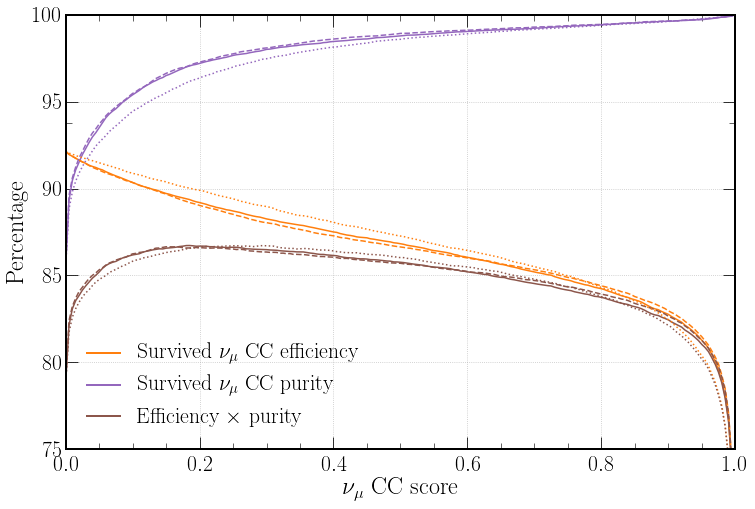

In [42]:
chipsnet.plotting.plot_eff_curves([outputs[0], outputs[1], outputs[2]], 1, save_path+"beam_numu_eff_curves")

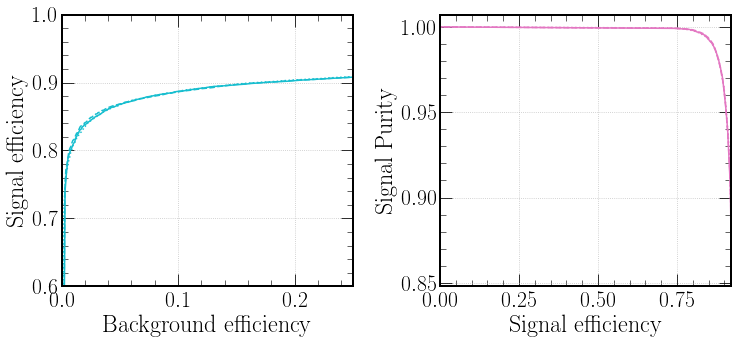

In [43]:
chipsnet.plotting.plot_comp_curves([outputs[0], outputs[1], outputs[2]], 1, save_path+"beam_numu_comp_curves")

In [44]:
# Tidy up
del outputs

<a id='energy_chan'></a>

## Does lepton energy help neutrino energy estimation? (energy_chan)
* There doesn't seem to be a noticable difference when both are trained together
* This has only been testing on nuel cc, it may be different for numu cc
* As its negligable we will train together using the learned approach as that seems best

In [45]:
events, outputs = chipsnet.utils.evaluate(
    config,
    "nuel_all",
    ["energy_nu", "energy_lep", "energy_nu_lep", "energy_nu_lep_learn"],
    ["energy", "energy", "energy", "energy"]
)


************************ Evaluating nuel_all ************************
Loading best checkpoint (10)
Loading best checkpoint (8)
Loading best checkpoint (10)
Loading best checkpoint (9)
Weights: (0,0.00000), (0,0.00000), (0,0.00000), (0,0.00000), (0,0.00000)
Cuts:    (165333,0.94588), (0,0.00000), (17569,0.66491), (0,0.00000)
took 672.93 seconds


In [46]:
ev = events[(events["cut"] == 0) & (events["t_comb_cat"] == 0) & (events["t_lep_energy"] != -1)]

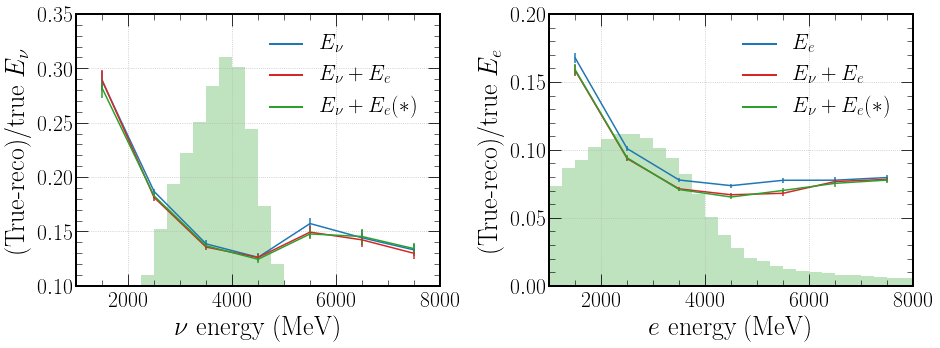

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={"hspace": 0.1, "wspace": 0.3})
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev, fit_name="energy_nu_frac_nu_energy")
axs[0].errorbar(e_list, std_list[0], yerr=std_list[1], color="tab:blue")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev, fit_name="energy_nu_lep_frac_nu_energy")
axs[0].errorbar(e_list, std_list[0], yerr=std_list[1], color="tab:red")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev, fit_name="energy_nu_lep_learn_frac_nu_energy")
axs[0].errorbar(e_list, std_list[0], yerr=std_list[1], color="tab:green")
axs[0].set(ylabel=r"(True-reco)/true $E_{\nu}$", xlabel=r"$\nu$ energy (MeV)")
axs[0].set_ylim(0.1, 0.35)
axs[0].set_xlim(1000, 8000)
axs[0].grid()
axs[0].hist(
    ev["t_nu_energy"],
    range=(1000, 8000),
    bins=28,
    color="tab:green",
    density=False,
    alpha=0.3,
    weights=ev["w"] * 0.00002,
)

e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev, fit_name="energy_lep_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list, std_list[0], yerr=std_list[1], color="tab:blue")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev, fit_name="energy_nu_lep_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list, std_list[0], yerr=std_list[1], color="tab:red")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev, fit_name="energy_nu_lep_learn_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list, std_list[0], yerr=std_list[1], color="tab:green")
axs[1].set(ylabel=r"(True-reco)/true $E_{e}$", xlabel=r"$e$ energy (MeV)")
axs[1].set_ylim(0.0, 0.2)
axs[1].set_xlim(1000, 8000)
axs[1].grid()
axs[1].hist(
    ev["t_lep_energy"],
    range=(1000, 8000),
    bins=28,
    color="tab:green",
    density=False,
    alpha=0.3,
    weights=ev["w"] * 0.00001,
)

nu = Line2D([0], [0], color="tab:blue", linewidth=2, linestyle="solid", label=r"$E_{\nu}$")
lep = Line2D([0], [0], color="tab:blue", linewidth=2, linestyle="solid", label=r"$E_{e}$")
multi = Line2D([0], [0], color="tab:red", linewidth=2, linestyle="solid", label=r"$E_{\nu}+E_{e}$")
multi_learn = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label=r"$E_{\nu}+E_{e}(*)$")
axs[0].legend(handles=[nu, multi, multi_learn], loc="upper right")
axs[1].legend(handles=[lep, multi, multi_learn], loc="upper right")

chipsnet.plotting.save(save_path + "energy_chan_frac_vs_e")

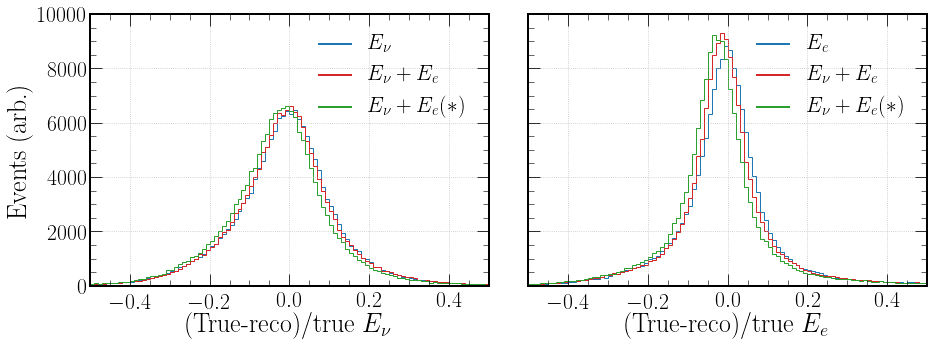

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={"hspace": 0.1, "wspace": 0.1})
axs[0].hist(
    ev['energy_nu_frac_nu_energy'], 
    weights=ev["w"], 
    range=(-0.5, 0.5), bins=100, histtype='step', color="tab:blue"
)
axs[0].hist(
    ev['energy_nu_lep_frac_nu_energy'], 
    weights=ev["w"],
    range=(-0.5, 0.5), bins=100, histtype='step', color="tab:red"
)
axs[0].hist(
    ev['energy_nu_lep_learn_frac_nu_energy'], 
    weights=ev["w"],
    range=(-0.5, 0.5), bins=100, histtype='step', color="tab:green"
)
axs[0].set(xlabel=r"(True-reco)/true $E_{\nu}$", ylabel=r"Events (arb.)")
axs[0].grid()
axs[0].label_outer()
axs[0].set_ylim(0, 10000)
axs[1].hist(
    ev['energy_lep_frac_lep_energy'], 
    weights=ev["w"],
    range=(-0.5, 0.5), bins=100, histtype='step', color="tab:blue"
)
axs[1].hist(
    ev['energy_nu_lep_frac_lep_energy'], 
    weights=ev["w"],
    range=(-0.5, 0.5), bins=100, histtype='step', color="tab:red"
)
axs[1].hist(
    ev['energy_nu_lep_learn_frac_lep_energy'], 
    weights=ev["w"],
    range=(-0.5, 0.5), bins=100, histtype='step', color="tab:green"
)
axs[1].set(xlabel=r"(True-reco)/true $E_{e}$")
axs[1].grid()
axs[1].label_outer()
axs[1].set_ylim(0, 10000)

nu = Line2D([0], [0], color="tab:blue", linewidth=2, linestyle="solid", label=r"$E_{\nu}$")
lep = Line2D([0], [0], color="tab:blue", linewidth=2, linestyle="solid", label=r"$E_{e}$")
multi = Line2D([0], [0], color="tab:red", linewidth=2, linestyle="solid", label=r"$E_{\nu}+E_{e}$")
multi_learn = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label=r"$E_{\nu}+E_{e}(*)$")
axs[0].legend(handles=[nu, multi, multi_learn], loc="upper right")
axs[1].legend(handles=[lep, multi, multi_learn], loc="upper right")

chipsnet.plotting.save(save_path + "energy_chan_frac_dist")

In [49]:
print(ev['energy_nu_frac_nu_energy'].describe())
print(ev['energy_nu_lep_frac_nu_energy'].describe())
print(ev['energy_nu_lep_learn_frac_nu_energy'].describe())

count    164453.000000
mean         -0.013052
std           0.144586
min          -0.840544
25%          -0.085366
50%          -0.007769
75%           0.061548
max           1.807193
Name: energy_nu_frac_nu_energy, dtype: float64
count    164453.000000
mean         -0.014588
std           0.144385
min          -0.843742
25%          -0.087094
50%          -0.010482
75%           0.057832
max           2.026635
Name: energy_nu_lep_frac_nu_energy, dtype: float64
count    164453.000000
mean         -0.029575
std           0.142855
min          -0.839813
25%          -0.101435
50%          -0.024232
75%           0.043107
max           1.790504
Name: energy_nu_lep_learn_frac_nu_energy, dtype: float64


In [50]:
print(ev['energy_lep_frac_lep_energy'].describe())
print(ev['energy_nu_lep_frac_lep_energy'].describe())
print(ev['energy_nu_lep_learn_frac_lep_energy'].describe())

count    164453.000000
mean          0.097969
std           1.027841
min          -0.885886
25%          -0.059739
50%          -0.003231
75%           0.053928
max         110.435778
Name: energy_lep_frac_lep_energy, dtype: float64
count    164453.000000
mean          0.092522
std           1.010968
min          -0.904872
25%          -0.062979
50%          -0.011571
75%           0.044597
max          88.661810
Name: energy_nu_lep_frac_lep_energy, dtype: float64
count    164453.000000
mean          0.075212
std           0.988510
min          -0.880429
25%          -0.078026
50%          -0.025521
75%           0.029832
max          93.887984
Name: energy_nu_lep_learn_frac_lep_energy, dtype: float64


In [51]:
# Tidy up
del events, outputs, ev

<a id='energy_par'></a>

## Does vertex/escapes energy help neutrino energy estimation? (energy_par)
* Adding the vtx (learned) looks like the best
* The differences are all very small
* As we have escapes in cosmic rejection having vtx here would be good

In [52]:
events, outputs = chipsnet.utils.evaluate(
    config,
    "nuel_all",
    ["energy_nu_lep_learn", "energy_nu_lep_vtx", "energy_nu_lep_vtx_learn", "energy_nu_lep_escapes", "energy_nu_lep_escapes_learn", "energy_nu_lep_vtx_escapes"],
    ["energy", "energy", "energy", "energy", "energy", "energy"]
)


************************ Evaluating nuel_all ************************
Loading best checkpoint (9)
Loading best checkpoint (9)
Loading best checkpoint (8)
Loading best checkpoint (9)
Loading best checkpoint (12)
Loading best checkpoint (10)
Weights: (0,0.00000), (0,0.00000), (0,0.00000), (0,0.00000), (0,0.00000)
Cuts:    (165333,0.94588), (0,0.00000), (17569,0.66491), (0,0.00000)
took 933.48 seconds


In [53]:
ev = events[(events["cut"] == 0) & (events["t_comb_cat"] == 0) & (events["t_lep_energy"] != -1)]

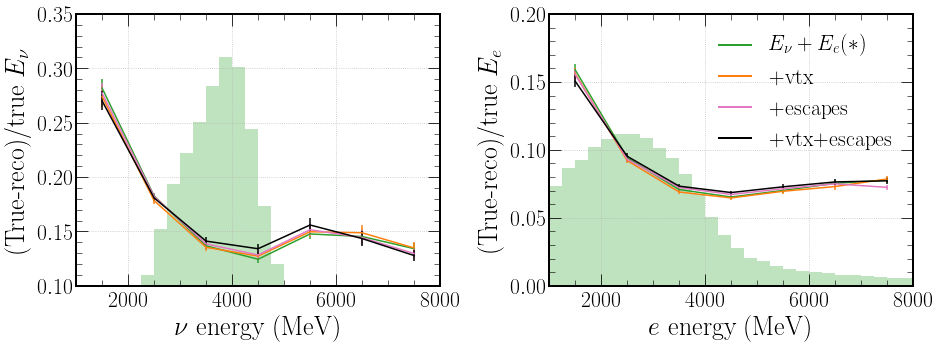

In [54]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={"hspace": 0.1, "wspace": 0.3})
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev, fit_name="energy_nu_lep_learn_frac_nu_energy")
axs[0].errorbar(e_list, std_list[0], yerr=std_list[1], color="tab:green")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev, fit_name="energy_nu_lep_vtx_learn_frac_nu_energy")
axs[0].errorbar(e_list, std_list[0], yerr=std_list[1], color="tab:orange")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev, fit_name="energy_nu_lep_escapes_learn_frac_nu_energy")
axs[0].errorbar(e_list, std_list[0], yerr=std_list[1], color="tab:pink")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev, fit_name="energy_nu_lep_vtx_escapes_frac_nu_energy")
axs[0].errorbar(e_list, std_list[0], yerr=std_list[1], color="black")
axs[0].set(ylabel=r"(True-reco)/true $E_{\nu}$", xlabel=r"$\nu$ energy (MeV)")
axs[0].set_ylim(0.1, 0.35)
axs[0].grid()
axs[0].hist(
    ev["t_nu_energy"],
    range=(1000, 8000),
    bins=28,
    color="tab:green",
    density=False,
    alpha=0.3,
    weights=ev["w"] * 0.00002,
)

e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev, fit_name="energy_nu_lep_learn_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list, std_list[0], yerr=std_list[1], color="tab:green")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev, fit_name="energy_nu_lep_vtx_learn_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list, std_list[0], yerr=std_list[1], color="tab:orange")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev, fit_name="energy_nu_lep_escapes_learn_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list, std_list[0], yerr=std_list[1], color="tab:pink")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev, fit_name="energy_nu_lep_vtx_escapes_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list, std_list[0], yerr=std_list[1], color="black")
axs[1].set(ylabel=r"(True-reco)/true $E_{e}$", xlabel=r"$e$ energy (MeV)")
axs[1].set_ylim(0.0, 0.2)
axs[1].grid()
axs[1].hist(
    ev["t_lep_energy"],
    range=(1000, 8000),
    bins=28,
    color="tab:green",
    density=False,
    alpha=0.3,
    weights=ev["w"] * 0.00001,
)

nu_lep = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label=r"$E_{\nu}+E_{e}(*)$")
vtx_learn = Line2D([0], [0], color="tab:orange", linewidth=2, linestyle="solid", label="+vtx")
escapes_learn = Line2D([0], [0], color="tab:pink", linewidth=2, linestyle="solid", label="+escapes")
both = Line2D([0], [0], color="black", linewidth=2, linestyle="solid", label="+vtx+escapes")
axs[1].legend(handles=[nu_lep, vtx_learn, escapes_learn, both], loc="upper right")

chipsnet.plotting.save(save_path + "energy_par_frac_vs_e")

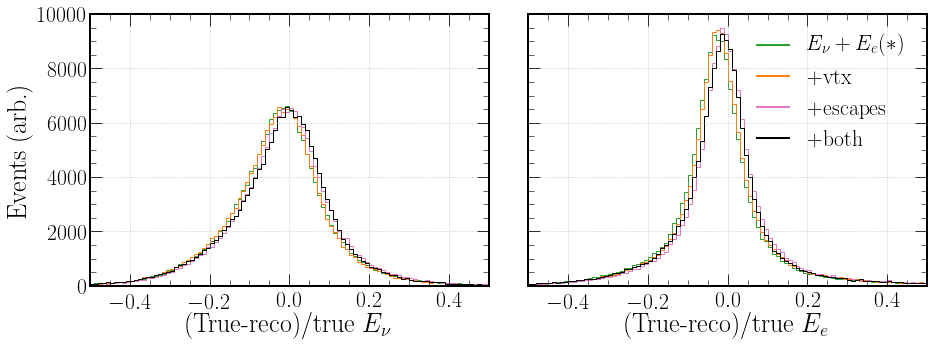

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={"hspace": 0.1, "wspace": 0.1})
axs[0].hist(
    ev['energy_nu_lep_learn_frac_nu_energy'], 
    weights=ev["w"], 
    range=(-0.5, 0.5), bins=100, histtype='step', color="tab:green"
)
axs[0].hist(
    ev['energy_nu_lep_vtx_learn_frac_nu_energy'], 
    weights=ev["w"],
    range=(-0.5, 0.5), bins=100, histtype='step', color="tab:orange"
)
axs[0].hist(
    ev['energy_nu_lep_escapes_learn_frac_nu_energy'], 
    weights=ev["w"],
    range=(-0.5, 0.5), bins=100, histtype='step', color="tab:pink"
)
axs[0].hist(
    ev['energy_nu_lep_vtx_escapes_frac_nu_energy'], 
    weights=ev["w"],
    range=(-0.5, 0.5), bins=100, histtype='step', color="black"
)
axs[0].set(xlabel=r"(True-reco)/true $E_{\nu}$", ylabel=r"Events (arb.)")
axs[0].grid()
axs[0].label_outer()
axs[0].set_ylim(0, 10000)
axs[1].hist(
    ev['energy_nu_lep_learn_frac_lep_energy'], 
    weights=ev["w"],
    range=(-0.5, 0.5), bins=100, histtype='step', color="tab:green"
)
axs[1].hist(
    ev['energy_nu_lep_vtx_learn_frac_lep_energy'], 
    weights=ev["w"],
    range=(-0.5, 0.5), bins=100, histtype='step', color="tab:orange"
)
axs[1].hist(
    ev['energy_nu_lep_escapes_learn_frac_lep_energy'], 
    weights=ev["w"],
    range=(-0.5, 0.5), bins=100, histtype='step', color="tab:pink"
)
axs[1].hist(
    ev['energy_nu_lep_vtx_escapes_frac_lep_energy'], 
    weights=ev["w"],
    range=(-0.5, 0.5), bins=100, histtype='step', color="black"
)
axs[1].set(xlabel=r"(True-reco)/true $E_{e}$")
axs[1].grid()
axs[1].label_outer()
axs[1].set_ylim(0, 10000)
nu_lep = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label=r"$E_{\nu}+E_{e}(*)$")
vtx_learn = Line2D([0], [0], color="tab:orange", linewidth=2, linestyle="solid", label="+vtx")
escapes_learn = Line2D([0], [0], color="tab:pink", linewidth=2, linestyle="solid", label="+escapes")
both = Line2D([0], [0], color="black", linewidth=2, linestyle="solid", label="+both")
axs[1].legend(handles=[nu_lep, vtx_learn, escapes_learn, both], loc="upper right")
chipsnet.plotting.save(save_path + "energy_par_frac_dist")

In [56]:
print(ev['energy_nu_lep_learn_frac_nu_energy'].describe())
print(ev['energy_nu_lep_vtx_frac_nu_energy'].describe())
print(ev['energy_nu_lep_vtx_learn_frac_nu_energy'].describe())
print(ev['energy_nu_lep_escapes_frac_nu_energy'].describe())
print(ev['energy_nu_lep_escapes_learn_frac_nu_energy'].describe())
print(ev['energy_nu_lep_vtx_escapes_frac_nu_energy'].describe())

count    164453.000000
mean         -0.029575
std           0.142855
min          -0.839813
25%          -0.101435
50%          -0.024232
75%           0.043107
max           1.790504
Name: energy_nu_lep_learn_frac_nu_energy, dtype: float64
count    164453.000000
mean         -0.018542
std           0.142980
min          -0.803901
25%          -0.090620
50%          -0.011801
75%           0.055323
max           1.760462
Name: energy_nu_lep_vtx_frac_nu_energy, dtype: float64
count    164453.000000
mean         -0.030495
std           0.142191
min          -0.819618
25%          -0.102560
50%          -0.024390
75%           0.042538
max           1.733317
Name: energy_nu_lep_vtx_learn_frac_nu_energy, dtype: float64
count    164453.000000
mean         -0.018522
std           0.143940
min          -0.851784
25%          -0.090634
50%          -0.013555
75%           0.054941
max           1.920683
Name: energy_nu_lep_escapes_frac_nu_energy, dtype: float64
count    164453.000000
mean     

In [57]:
print(ev['energy_nu_lep_learn_frac_lep_energy'].describe())
print(ev['energy_nu_lep_vtx_frac_lep_energy'].describe())
print(ev['energy_nu_lep_vtx_learn_frac_lep_energy'].describe())
print(ev['energy_nu_lep_escapes_frac_lep_energy'].describe())
print(ev['energy_nu_lep_escapes_learn_frac_lep_energy'].describe())
print(ev['energy_nu_lep_vtx_escapes_frac_lep_energy'].describe())

count    164453.000000
mean          0.075212
std           0.988510
min          -0.880429
25%          -0.078026
50%          -0.025521
75%           0.029832
max          93.887984
Name: energy_nu_lep_learn_frac_lep_energy, dtype: float64
count    164453.000000
mean          0.095222
std           1.008049
min          -0.877976
25%          -0.067525
50%          -0.015482
75%           0.040881
max          81.712339
Name: energy_nu_lep_vtx_frac_lep_energy, dtype: float64
count    164453.000000
mean          0.091186
std           1.019198
min          -0.892481
25%          -0.070147
50%          -0.020177
75%           0.036634
max          88.127675
Name: energy_nu_lep_vtx_learn_frac_lep_energy, dtype: float64
count    164453.000000
mean          0.090999
std           1.003602
min          -0.883374
25%          -0.067731
50%          -0.015515
75%           0.042031
max          97.927773
Name: energy_nu_lep_escapes_frac_lep_energy, dtype: float64
count    164453.000000
mean 

In [58]:
# Tidy up
del events, outputs, ev

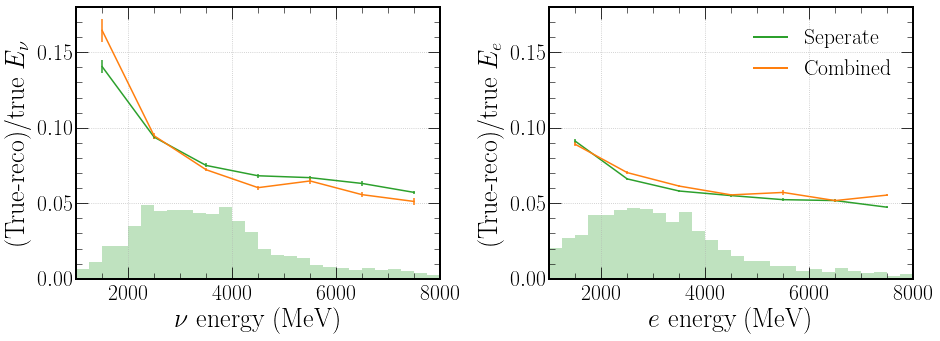

In [17]:
ev_s = nuel_ccqel_ev[(nuel_ccqel_ev["cut"] == 0) & (nuel_ccqel_ev["t_all_cat"] == 0) & (nuel_ccqel_ev["t_lep_energy"] != -1)]
ev_f = flux_ev[(flux_ev["cut"] == 0) & (flux_ev["t_all_cat"] == 0) & (flux_ev["t_lep_energy"] != -1)]

fig, axs = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={"hspace": 0.1, "wspace": 0.3})
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev_s, fit_name="final_nuel_ccqel_e_frac_nu_energy")
axs[0].errorbar(e_list, std_list[0], yerr=std_list[1], color="tab:green")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev_f, fit_name="final_nuel_cc_e_frac_nu_energy")
axs[0].errorbar(e_list, std_list[0], yerr=std_list[1], color="tab:orange")
axs[0].set(ylabel=r"(True-reco)/true $E_{\nu}$", xlabel=r"$\nu$ energy (MeV)")
axs[0].set_ylim(0.0, 0.18)
axs[0].grid()
axs[0].hist(
    ev_f["t_nu_energy"],
    range=(1000, 8000),
    bins=28,
    color="tab:green",
    density=False,
    alpha=0.3,
    weights=ev_f["w"] * 0.05,
)

e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev_s, fit_name="final_nuel_ccqel_e_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list, std_list[0], yerr=std_list[1], color="tab:green")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev_f, fit_name="final_nuel_cc_e_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list, std_list[0], yerr=std_list[1], color="tab:orange")
axs[1].set(ylabel=r"(True-reco)/true $E_{e}$", xlabel=r"$e$ energy (MeV)")
axs[1].set_ylim(0.0, 0.18)
axs[1].grid()
axs[1].hist(
    ev_f["t_lep_energy"],
    range=(1000, 8000),
    bins=28,
    color="tab:green",
    density=False,
    alpha=0.3,
    weights=ev_f["w"] * 0.05,
)

seperate = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label=r"Seperate")
combined = Line2D([0], [0], color="tab:orange", linewidth=2, linestyle="solid", label="Combined")
axs[1].legend(handles=[seperate, combined], loc="upper right")

chipsnet.plotting.save(save_path + "energy_split_frac_vs_e")

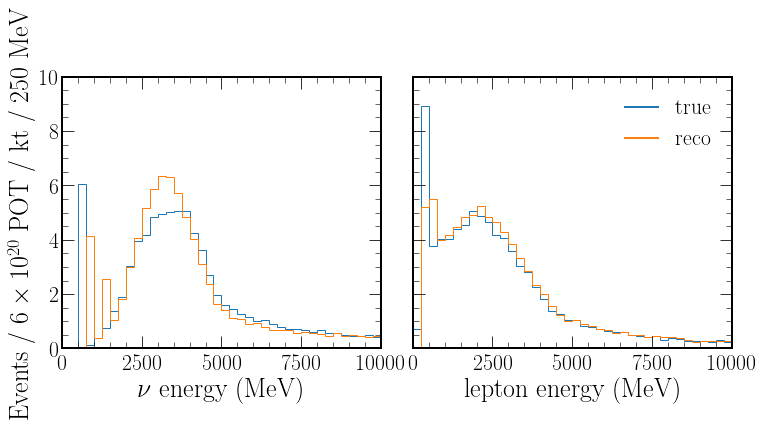

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={"hspace": 0.1, "wspace": 0.1})
axs[0].hist(flux_ev[(flux_ev["t_comb_cat"] == 0) & (flux_ev["t_lep_energy"] != 0.0)]['t_nu_energy'], 
            weights=flux_ev[(flux_ev["t_comb_cat"] == 0) & (flux_ev["t_lep_energy"] != 0.0)]['w'],
            range=(0, 10000), bins=40, histtype='step', color="tab:blue")
axs[0].hist(flux_ev[(flux_ev["t_comb_cat"] == 0) & (flux_ev["t_lep_energy"] != 0.0)]['final_nuel_cc_e_pred_t_nu_energy'], 
            weights=flux_ev[(flux_ev["t_comb_cat"] == 0) & (flux_ev["t_lep_energy"] != 0.0)]['w'],
            range=(0, 10000), bins=40, histtype='step', color="tab:orange")
axs[0].set(xlabel=r"$\nu$ energy (MeV)", ylabel=r"Events / $6\times10^{20}$ POT / kt / 250 MeV")
axs[0].label_outer()
axs[0].set_ylim(0, 10)
axs[1].hist(flux_ev[(flux_ev["t_comb_cat"] == 0) & (flux_ev["t_lep_energy"] != 0.0)]['t_lep_energy'], 
            weights=flux_ev[(flux_ev["t_comb_cat"] == 0) & (flux_ev["t_lep_energy"] != 0.0)]['w'],
            range=(0, 10000), bins=40, histtype='step', color="tab:blue")
axs[1].hist(flux_ev[(flux_ev["t_comb_cat"] == 0) & (flux_ev["t_lep_energy"] != 0.0)]['final_nuel_cc_e_pred_t_lep_energy'], 
            weights=flux_ev[(flux_ev["t_comb_cat"] == 0) & (flux_ev["t_lep_energy"] != 0.0)]['w'],
            range=(0, 10000), bins=40, histtype='step', color="tab:orange")
axs[1].set(xlabel=r"lepton energy (MeV)")
axs[1].label_outer()
axs[1].set_ylim(0, 10)
single = Line2D([0], [0], color="tab:blue", linewidth=2, linestyle="solid", label="true")
multi = Line2D([0], [0], color="tab:orange", linewidth=2, linestyle="solid", label="reco")
axs[1].legend(handles=[single, multi], loc="upper right")
chipsnet.plotting.save(save_path + "energy_split_dists")

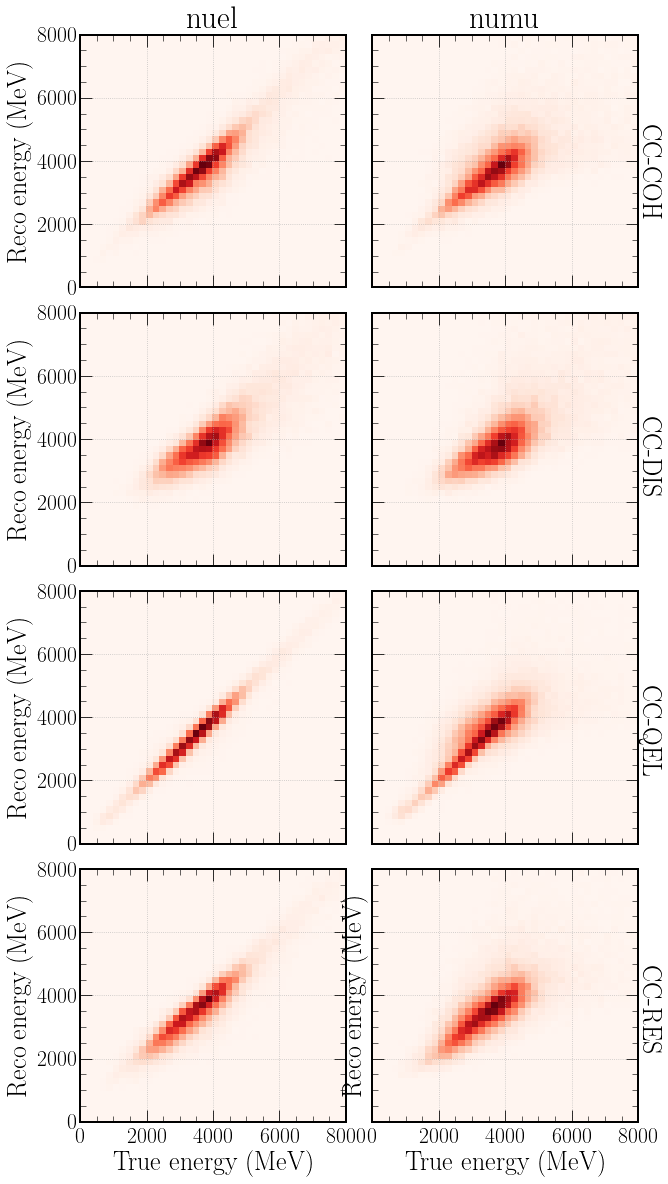

In [30]:
e_range = [[0, 8000], [0, 8000]]
e_bins = [40, 40]
fig, axs = plt.subplots(4, 2, figsize=(10, 20), gridspec_kw={"hspace": 0.1, "wspace": 0.1})
plt.setp(axs, xticks=[0, 2000, 4000, 6000, 8000], yticks=[0, 2000, 4000, 6000, 8000])
axs[0, 0].hist2d(nuel_cccoh_ev["t_nu_energy"], nuel_cccoh_ev["final_nuel_cccoh_e_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[0, 0].grid()
axs[0, 0].label_outer()
axs[0, 0].set(ylabel=r"Reco energy (MeV)")
axs[0, 0].set_title(r"nuel")
axs[1, 0].hist2d(nuel_ccdis_ev["t_nu_energy"], nuel_ccdis_ev["final_nuel_ccdis_e_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[1, 0].grid()
axs[1, 0].label_outer()
axs[1, 0].set(ylabel=r"Reco energy (MeV)")
axs[2, 0].hist2d(nuel_ccqel_ev["t_nu_energy"], nuel_ccqel_ev["final_nuel_ccqel_e_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[2, 0].grid()
axs[2, 0].label_outer()
axs[2, 0].set(ylabel=r"Reco energy (MeV)")
axs[3, 0].hist2d(nuel_ccres_ev["t_nu_energy"], nuel_ccres_ev["final_nuel_ccres_e_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[3, 0].grid()
axs[3, 0].label_outer()
axs[3, 0].set(xlabel=r"True energy (MeV)", ylabel=r"Reco energy (MeV)")
axs[0, 1].hist2d(numu_cccoh_ev["t_nu_energy"], numu_cccoh_ev["final_numu_cccoh_e_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[0, 1].grid()
axs[0, 1].label_outer()
axs[0, 1].set_title(r"numu")
axs[0, 1].text(8000, 2250, "CC-COH", rotation=-90)
axs[1, 1].hist2d(numu_ccdis_ev["t_nu_energy"], numu_ccdis_ev["final_numu_ccdis_e_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[1, 1].grid()
axs[1, 1].label_outer()
axs[1, 1].text(8000, 2250, "CC-DIS", rotation=-90)
axs[2, 1].hist2d(numu_ccqel_ev["t_nu_energy"], numu_ccqel_ev["final_numu_ccqel_e_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[2, 1].grid()
axs[2, 1].label_outer()
axs[2, 1].text(8000, 2250, "CC-QEL", rotation=-90)
axs[3, 1].hist2d(numu_ccres_ev["t_nu_energy"], numu_ccres_ev["final_numu_ccres_e_pred_t_nu_energy"],
                 range=e_range, bins=e_bins, cmap="Reds")
axs[3, 1].grid()
axs[3, 1].label_outer()
axs[3, 1].text(8000, 2250, "CC-RES", rotation=-90)
axs[3, 1].set(xlabel=r"True energy (MeV)", ylabel=r"Reco energy (MeV)")
chipsnet.plotting.save(save_path + "true_vs_reco_energy_cc")

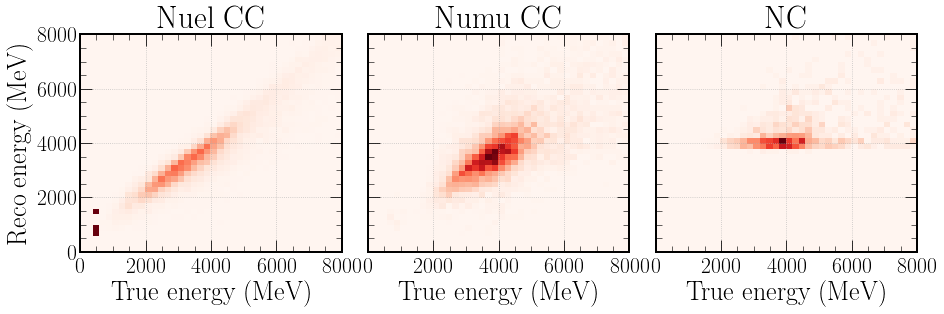

In [31]:
e_range = [[0, 8000], [0, 8000]]
e_bins = [40, 40]
fig, axs = plt.subplots(1, 3, figsize=(15, 4), gridspec_kw={"hspace": 0.1, "wspace": 0.1})
plt.setp(axs, xticks=[0, 2000, 4000, 6000, 8000], yticks=[0, 2000, 4000, 6000, 8000])
axs[0].hist2d(flux_ev[flux_ev["t_comb_cat"] == 0]["t_nu_energy"], flux_ev[flux_ev["t_comb_cat"] == 0]["final_nuel_cc_e_pred_t_nu_energy"],
              range=e_range, bins=e_bins, weights=flux_ev[flux_ev["t_comb_cat"] == 0]["w"], cmap="Reds")
axs[0].grid()
axs[0].label_outer()
axs[0].set(xlabel=r"True energy (MeV)", ylabel=r"Reco energy (MeV)")
axs[0].set_title(r"Nuel CC")
axs[1].hist2d(flux_ev[flux_ev["t_comb_cat"] == 1]["t_nu_energy"], flux_ev[flux_ev["t_comb_cat"] == 1]["final_numu_cc_e_pred_t_nu_energy"],
              range=e_range, bins=e_bins, weights=flux_ev[flux_ev["t_comb_cat"] == 1]["w"], cmap="Reds")
axs[1].grid()
axs[1].label_outer()
axs[1].set(xlabel=r"True energy (MeV)")
axs[1].set_title(r"Numu CC")
axs[2].hist2d(flux_ev[flux_ev["t_comb_cat"] == 2]["t_nu_energy"], flux_ev[flux_ev["t_comb_cat"] == 2]["final_nc_e_pred_t_nu_energy"],
              range=e_range, bins=e_bins, weights=flux_ev[flux_ev["t_comb_cat"] == 2]["w"], cmap="Reds")
axs[2].grid()
axs[2].label_outer()
axs[2].set(xlabel=r"True energy (MeV)")
axs[2].set_title(r"NC")
chipsnet.plotting.save(save_path + "true_vs_reco_energy_comb")

<a id='final'></a>

## Final performance and comparison with old reco/pid (final)
* 1
* 2
* 3

In [4]:
events, outputs = chipsnet.utils.evaluate(
    config, "flux_cosmic", 
    ["final_cosmic", "final_beam", "final_nuel_cc_e", "final_numu_cc_e", "final_nc_e",
     "final_nuel_cccoh_e", "final_nuel_ccdis_e", "final_nuel_ccqel_e", "final_nuel_ccres_e",
     "final_numu_cccoh_e", "final_numu_ccdis_e", "final_numu_ccqel_e", "final_numu_ccres_e"],
    ["t_cosmic_cat", "t_comb_cat", "energy", "energy", "energy",
     "energy", "energy", "energy", "energy",
     "energy", "energy", "energy", "energy"]
)


************************ Evaluating flux_cosmic ************************
Loading best checkpoint (3)
Loading best checkpoint (4)
Loading best checkpoint (14)
Loading best checkpoint (4)
Loading best checkpoint (3)
Loading best checkpoint (10)
Loading best checkpoint (13)
Loading best checkpoint (17)
Loading best checkpoint (18)
Loading best checkpoint (10)
Loading best checkpoint (8)
Loading best checkpoint (17)
Loading best checkpoint (12)
Weights: (22787,0.00171), (38385,0.00007), (40193,0.08343), (69834,0.00105), (48820,24.79922)
count    48820.000000
mean         0.998852
std          0.022133
min          0.005598
25%          0.999989
50%          0.999999
75%          1.000000
max          1.000000
Name: final_cosmic_pred_t_cosmic_cat, dtype: float64
Cuts:    (76573,0.92491), (85744,0.90355), (19339,0.65571), (0,0.00000)

------------------------ final_beam report ------------------------
- Comb-> Prec: (0.99979,0.79082), Rec: (0.99974,0.85377), F1: (0.99975,0.78816)
- Cat->  P

In [ ]:
# Get events run through old reco/pid for comparisons
old_events = pd.concat([
    chipsnet.utils.get_old_df(old_nuel_file, 11),
    chipsnet.utils.get_old_df(old_numu_file, 13)
])

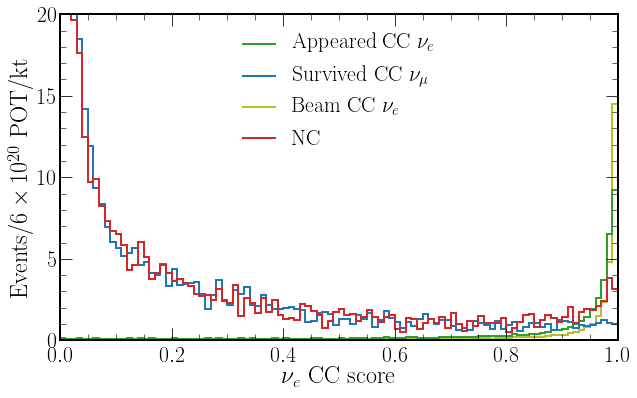

In [5]:
chipsnet.plotting.plot_combined_values(events, 0, "final_beam_", save_path+"final_beam_nuel_outputs")

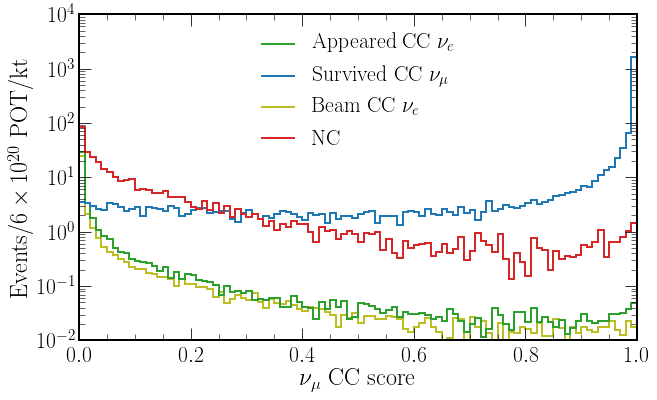

In [19]:
chipsnet.plotting.plot_combined_values(events, 1, "final_beam_", save_path+"final_beam_numu_outputs")

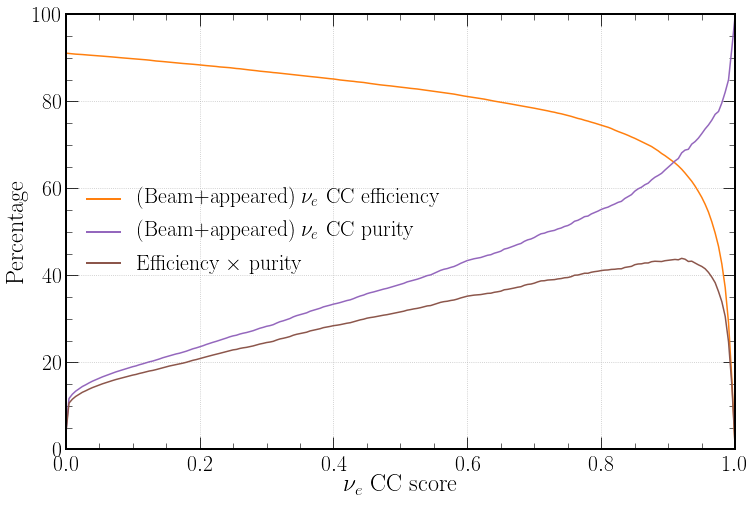

In [7]:
chipsnet.plotting.plot_eff_curves([outputs[0]], 0, save_path+"final_nuel_eff_curves")

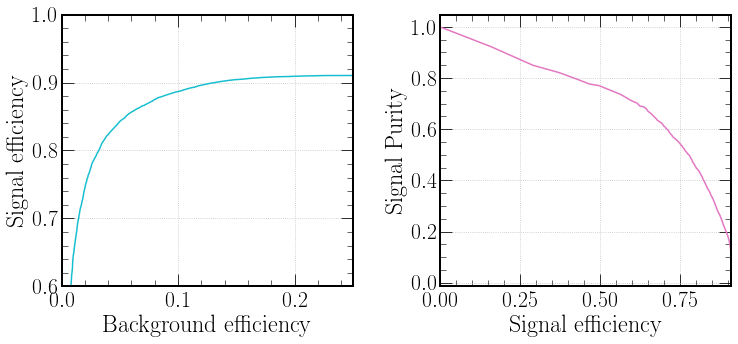

In [8]:
chipsnet.plotting.plot_comp_curves([outputs[0]], 0, save_path+"final_nuel_comp_curves")

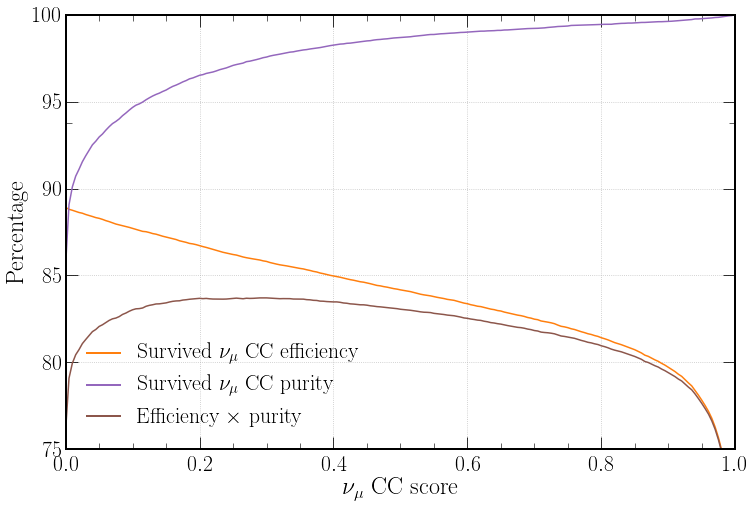

In [9]:
chipsnet.plotting.plot_eff_curves([outputs[0]], 1, save_path+"final_numu_eff_curves")

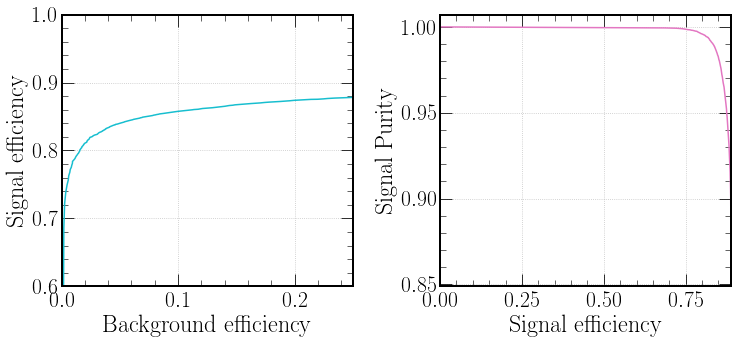

In [10]:
chipsnet.plotting.plot_comp_curves([outputs[0]], 1, save_path+"final_numu_comp_curves")

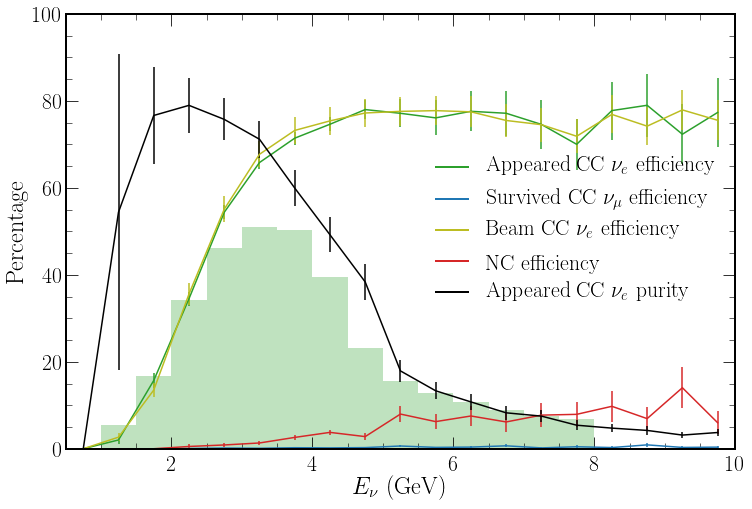

In [29]:
chipsnet.plotting.plot_nuel_hists([outputs[0]], events, save_path+"final_nuel_hists")

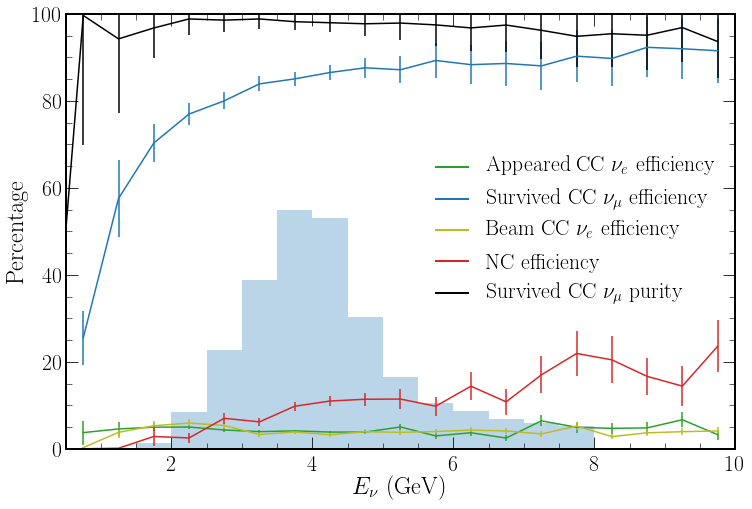

In [30]:
chipsnet.plotting.plot_numu_hists([outputs[0]], events, save_path+"final_numu_hists")

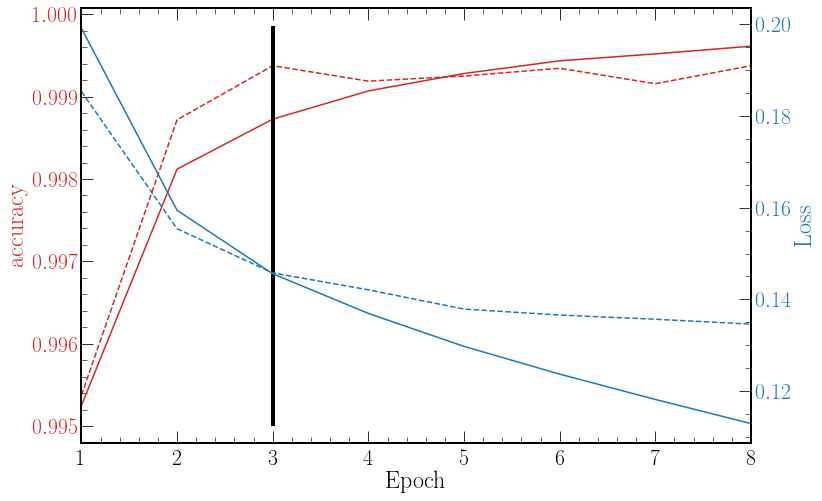

In [46]:
chipsnet.plotting.plot_history(config, "final_cosmic", save_path+"final_cosmic_history", key="t_cosmic_cat_accuracy")

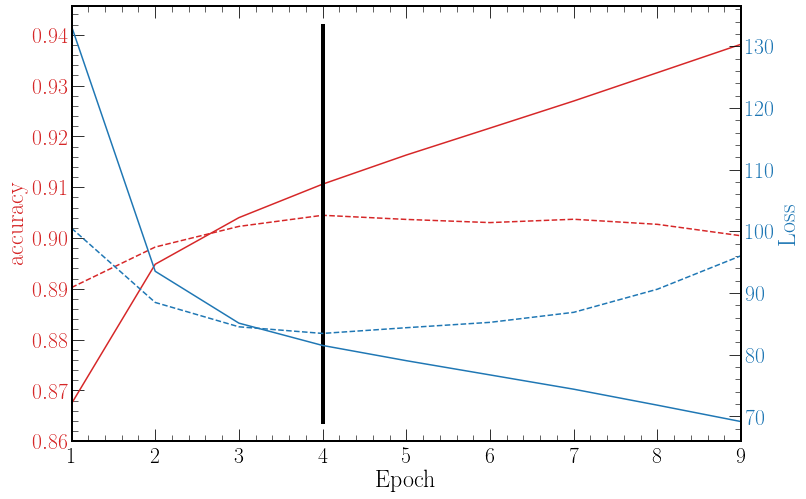

In [47]:
chipsnet.plotting.plot_history(config, "final_beam", save_path+"final_beam_history", key="t_comb_cat_accuracy")

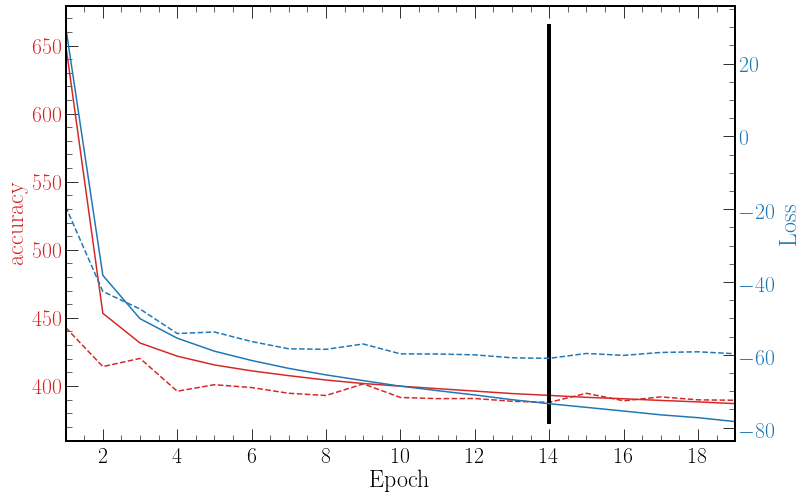

In [48]:
chipsnet.plotting.plot_history(config, "final_nuel_cc_e", save_path+"final_energy_history", key="t_nu_energy_mae", type="min")

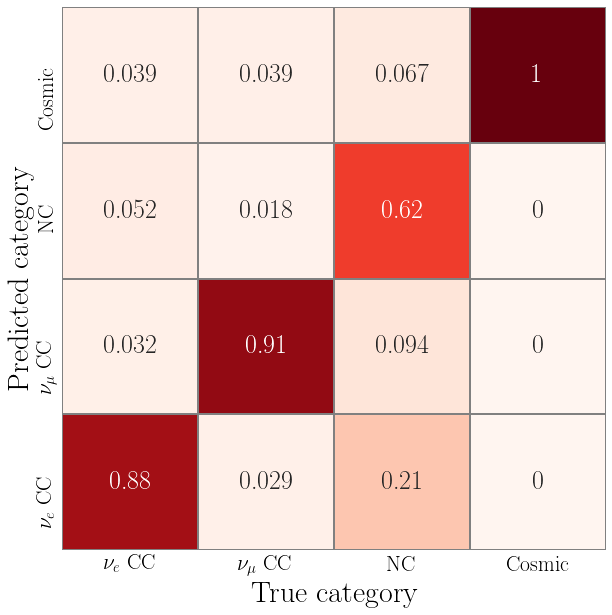

In [49]:
plt.figure(figsize=(10, 10))
sns.heatmap(
    outputs[0]["comb_matrix"],
    annot=True, 
    vmin=0.0, 
    vmax=1.0,
    xticklabels=chipsnet.data.MAP_FULL_COMB_CAT["labels"],
    yticklabels=chipsnet.data.MAP_FULL_COMB_CAT["labels"][::-1],
    cbar=False,
    square=True,
    linewidth=1,
    linecolor="grey",
    cmap="Reds")
plt.tick_params(axis='both', which='both',
                bottom=False, top=False, left=False, right=False)
plt.xlabel('True category', fontsize = 30)
plt.ylabel('Predicted category', fontsize = 30)
chipsnet.plotting.save(save_path + "final_comb_cat_confusion")

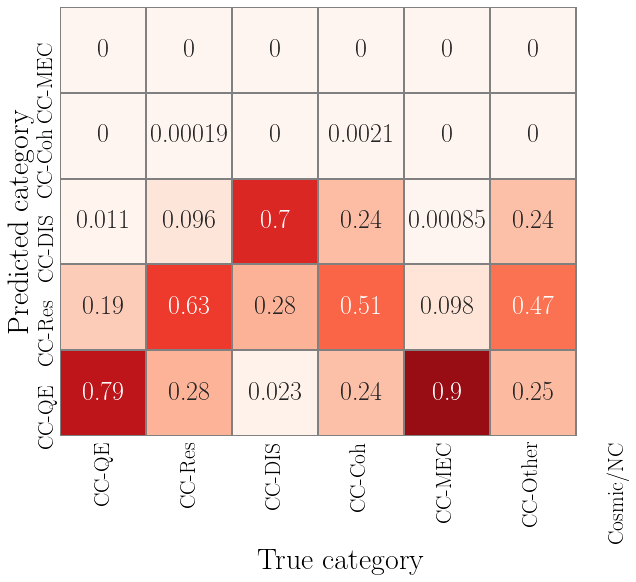

In [50]:
events["final_beam_t_cc_cat_class"] = events.apply(
    chipsnet.utils.classify,
    axis=1,
    args=(chipsnet.data.get_map("t_cc_cat")["categories"], "final_beam_pred_t_cc_cat_"),
)
cc_matrix = confusion_matrix(
    events[(events["cosmic_cut"] == 0) & (events["final_beam_comb_cat_class"] != 2)]["t_cc_cat"],
    events[(events["cosmic_cut"] == 0) & (events["final_beam_comb_cat_class"] != 2)]["final_beam_t_cc_cat_class"],
    labels=[x for x in range(6)],
    sample_weight=events[(events["cosmic_cut"] == 0) & (events["final_beam_comb_cat_class"] != 2)]["w"],
    normalize="true",
)
cc_matrix = np.rot90(cc_matrix, 1)
cc_matrix = pd.DataFrame(cc_matrix)
cc_matrix = cc_matrix.drop([0])
plt.figure(figsize=(10, 10))
sns.heatmap(
    cc_matrix,
    annot=True, 
    vmin=0.0, 
    vmax=1.0,
    xticklabels=chipsnet.data.MAP_CC_CAT["labels"],
    yticklabels=chipsnet.data.MAP_CC_CAT["labels"][:5][::-1],
    cbar=False,
    square=True,
    linewidth=1,
    linecolor="grey",
    cmap="Reds")
plt.tick_params(axis='both', which='both',
                bottom=False, top=False, left=False, right=False)
plt.xlabel('True category', fontsize = 30)
plt.ylabel('Predicted category', fontsize = 30)
chipsnet.plotting.save(save_path + "final_cc_cat_confusion")

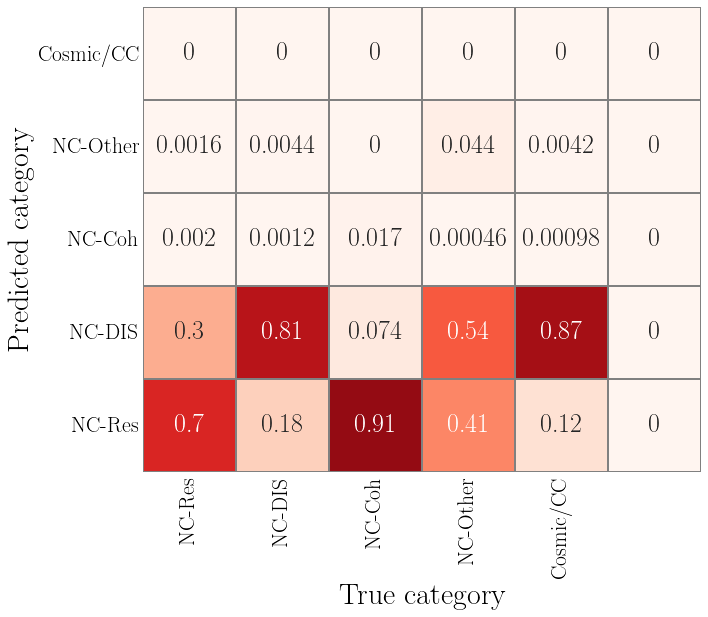

In [51]:
events["final_beam_t_nc_cat_class"] = events.apply(
    chipsnet.utils.classify,
    axis=1,
    args=(chipsnet.data.get_map("t_nc_cat")["categories"], "final_beam_pred_t_nc_cat_"),
)
nc_matrix = confusion_matrix(
    events[(events["cosmic_cut"] == 0) & (events["final_beam_comb_cat_class"] == 2)]["t_nc_cat"],
    events[(events["cosmic_cut"] == 0) & (events["final_beam_comb_cat_class"] == 2)]["final_beam_t_nc_cat_class"],
    labels=[x for x in range(6)],
    sample_weight=events[(events["cosmic_cut"] == 0) & (events["final_beam_comb_cat_class"] == 2)]["w"],
    normalize="true",
)
nc_matrix = np.rot90(nc_matrix, 1)
nc_matrix = pd.DataFrame(nc_matrix)
nc_matrix = nc_matrix.drop([0])
plt.figure(figsize=(10, 10))
sns.heatmap(
    nc_matrix,
    annot=True, 
    vmin=0.0, 
    vmax=1.0,
    xticklabels=chipsnet.data.MAP_NC_CAT["labels"],
    yticklabels=chipsnet.data.MAP_NC_CAT["labels"][:5][::-1],
    cbar=False,
    square=True,
    linewidth=1,
    linecolor="grey",
    cmap="Reds")
plt.tick_params(axis='both', which='both',
                bottom=False, top=False, left=False, right=False)
plt.xlabel('True category', fontsize = 30)
plt.ylabel('Predicted category', fontsize = 30)
chipsnet.plotting.save(save_path + "final_nc_cat_confusion")

In [ ]:
out_80 = chipsnet.utils.calculate_eff_pur(events[(events["final_beam_frac_lep_energy"] >= 0.8) & (events["final_beam_frac_lep_energy"] < 1.0)], outputs[0]["max_fom_cuts_0"], prefix="final_beam_")
out_60 = chipsnet.utils.calculate_eff_pur(events[(events["final_beam_frac_lep_energy"] >= 0.6) & (events["final_beam_frac_lep_energy"] < 0.8)], outputs[0]["max_fom_cuts_0"], prefix="final_beam_")
out_40 = chipsnet.utils.calculate_eff_pur(events[(events["final_beam_frac_lep_energy"] >= 0.4) & (events["final_beam_frac_lep_energy"] < 0.6)], outputs[0]["max_fom_cuts_0"], prefix="final_beam_")
out_20 = chipsnet.utils.calculate_eff_pur(events[(events["final_beam_frac_lep_energy"] >= 0.2) & (events["final_beam_frac_lep_energy"] < 0.4)], outputs[0]["max_fom_cuts_0"], prefix="final_beam_")

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(12, 8))
bins = np.arange(1.25, 8.25, 0.5)
axs.errorbar(
    bins,
    out_80["fom_effs"][0][0][0],
    yerr=out_80["fom_effs"][0][0][1],
    color="tab:green"
)
axs.errorbar(
    bins,
    out_60["fom_effs"][0][0][0],
    yerr=out_60["fom_effs"][0][0][1],
    color="tab:blue"
)
axs.errorbar(
    bins,
    out_40["fom_effs"][0][0][0],
    yerr=out_40["fom_effs"][0][0][1],
    color="tab:red"
)
axs.errorbar(
    bins,
    out_20["fom_effs"][0][0][0],
    yerr=out_20["fom_effs"][0][0][1],
    color="tab:pink"
)
axs.set_xlabel("Neutrino energy (GeV)", fontsize=24)
axs.set_ylabel("Efficiency", fontsize=24)
axs.set_ylim([0, 1])
leg_80 = Line2D([0], [0], color="tab:green", linewidth=2, label=r"80\% - 100\%")
leg_60 = Line2D([0], [0], color="tab:blue", linewidth=2, label=r"60\% - 80\%")
leg_40 = Line2D([0], [0], color="tab:red", linewidth=2, label=r"40\% - 60\%")
leg_20 = Line2D([0], [0], color="tab:pink", linewidth=2, label=r"20\% - 40\%")
axs.legend(handles=[leg_80, leg_60, leg_40, leg_20], loc="upper left")
chipsnet.plotting.save(save_path + "final_frac_energy_eff")

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10), gridspec_kw={'hspace': 0.3})
axs[0, 0].hist(
    events[(events["cut"] == 0) & (events["final_beam_comb_cat_class"] == 0) & (events["final_beam_t_cc_cat_class"] == 0)]["final_nuel_cc_e_frac_lep_energy"],
    bins=40, range=(-0.5, 0.5), color='tab:red', histtype='step'
)
axs[0, 0].hist(
    events[(events["cut"] == 0) & (events["final_beam_comb_cat_class"] == 0) & (events["final_beam_t_cc_cat_class"] == 0)]["final_nuel_ccqel_e_frac_lep_energy"],
    bins=40, range=(-0.5, 0.5), color='tab:blue', histtype='step'
)
axs[0, 1].hist(
    events[(events["cut"] == 0) & (events["final_beam_comb_cat_class"] == 0) & (events["final_beam_t_cc_cat_class"] == 1)]["final_nuel_cc_e_frac_lep_energy"],
    bins=40, range=(-0.5, 0.5), color='tab:red', histtype='step'
)
axs[0, 1].hist(
    events[(events["cut"] == 0) & (events["final_beam_comb_cat_class"] == 0) & (events["final_beam_t_cc_cat_class"] == 1)]["final_nuel_ccres_e_frac_lep_energy"],
    bins=40, range=(-0.5, 0.5), color='tab:blue', histtype='step'
)
axs[1, 0].hist(
    events[(events["cut"] == 0) & (events["final_beam_comb_cat_class"] == 0) & (events["final_beam_t_cc_cat_class"] == 2)]["final_nuel_cc_e_frac_lep_energy"],
    bins=40, range=(-0.5, 0.5), color='tab:red', histtype='step'
)
axs[1, 0].hist(
    events[(events["cut"] == 0) & (events["final_beam_comb_cat_class"] == 0) & (events["final_beam_t_cc_cat_class"] == 2)]["final_nuel_ccdis_e_frac_lep_energy"],
    bins=40, range=(-0.5, 0.5), color='tab:blue', histtype='step'
)
axs[1, 1].hist(
    events[(events["cut"] == 0) & (events["final_beam_comb_cat_class"] == 0) & (events["final_beam_t_cc_cat_class"] == 3)]["final_nuel_cc_e_frac_lep_energy"],
    bins=40, range=(-0.5, 0.5), color='tab:red', histtype='step'
)
axs[1, 1].hist(
    events[(events["cut"] == 0) & (events["final_beam_comb_cat_class"] == 0) & (events["final_beam_t_cc_cat_class"] == 3)]["final_nuel_cccoh_e_frac_lep_energy"],
    bins=40, range=(-0.5, 0.5), color='tab:blue', histtype='step'
)
plt.show()

In [ ]:
np.sqrt(np.mean(np.square(events[(events["cut"] == 0) & (events["final_beam_comb_cat_class"] == 1) & (events["final_beam_t_cc_cat_class"] == 0)]["final_numu_cc_e_frac_nu_energy"])))

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'hspace': 0.3})
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["cut"] == 0) & (events["t_all_cat"] == 0)], fit_name="final_nuel_ccqel_e_frac_nu_energy"
)
axs[0].errorbar(e_list, means[0], yerr=means[1], color="tab:green", linestyle="", marker="o")
axs[1].errorbar(e_list, stds[0], yerr=stds[1], color="tab:green", linestyle="", marker="o")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["cut"] == 0) & (events["t_all_cat"] == 1)], fit_name="final_nuel_ccres_e_frac_nu_energy"
)
axs[0].errorbar(e_list, means[0], yerr=means[1], color="tab:red", linestyle="", marker="o")
axs[1].errorbar(e_list, stds[0], yerr=stds[1], color="tab:red", linestyle="", marker="o")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["cut"] == 0) & (events["t_all_cat"] == 2)], fit_name="final_nuel_ccdis_e_frac_nu_energy"
)
axs[0].errorbar(e_list, means[0], yerr=means[1], color="tab:blue", linestyle="", marker="o")
axs[1].errorbar(e_list, stds[0], yerr=stds[1], color="tab:blue", linestyle="", marker="o")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["cut"] == 0) & (events["t_all_cat"] == 3)], fit_name="final_nuel_cccoh_e_frac_nu_energy"
)
axs[0].errorbar(e_list, means[0], yerr=means[1], color="tab:pink", linestyle="", marker="o")
axs[1].errorbar(e_list, stds[0], yerr=stds[1], color="tab:pink", linestyle="", marker="o")
axs[0].set_ylim(-0.4, 0.4)
axs[0].set_xlim(1000, 8000)
axs[1].set_ylim(0.0, 0.4)
axs[1].set_xlim(1000, 8000)
axs[0].grid()
axs[1].grid()
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'hspace': 0.3})
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["cut"] == 0) & (events["final_beam_pred_t_comb_cat_0"] >= outputs[0]["max_fom_cuts_0"][0]) & (events["final_beam_t_cc_cat_class"] == 0)], 
    fit_name="final_nuel_ccqel_e_frac_nu_energy",
    bin_size=2000
)
axs[0].errorbar(e_list, means[0], yerr=means[1], color="tab:green", linestyle="", marker="o")
axs[1].errorbar(e_list, stds[0], yerr=stds[1], color="tab:green", linestyle="", marker="o")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["cut"] == 0) & (events["final_beam_pred_t_comb_cat_0"] >= outputs[0]["max_fom_cuts_0"][0]) & (events["final_beam_t_cc_cat_class"] == 1)], 
    fit_name="final_nuel_ccres_e_frac_nu_energy",
    bin_size=2000
)
axs[0].errorbar(e_list, means[0], yerr=means[1], color="tab:red", linestyle="", marker="o")
axs[1].errorbar(e_list, stds[0], yerr=stds[1], color="tab:red", linestyle="", marker="o")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["cut"] == 0) & (events["final_beam_pred_t_comb_cat_0"] >= outputs[0]["max_fom_cuts_0"][0]) & (events["final_beam_t_cc_cat_class"] == 2)],
    fit_name="final_nuel_ccdis_e_frac_nu_energy",
    bin_size=2000
)
axs[0].errorbar(e_list, means[0], yerr=means[1], color="tab:blue", linestyle="", marker="o")
axs[1].errorbar(e_list, stds[0], yerr=stds[1], color="tab:blue", linestyle="", marker="o")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["cut"] == 0) & (events["final_beam_pred_t_comb_cat_0"] >= outputs[0]["max_fom_cuts_0"][0]) & (events["final_beam_t_cc_cat_class"] == 3)],
    fit_name="final_nuel_cccoh_e_frac_nu_energy",
    bin_size=2000
)
axs[0].errorbar(e_list, means[0], yerr=means[1], color="tab:pink", linestyle="", marker="o")
axs[1].errorbar(e_list, stds[0], yerr=stds[1], color="tab:pink", linestyle="", marker="o")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["cut"] == 0) & (events["final_beam_pred_t_comb_cat_0"] >= outputs[0]["max_fom_cuts_0"][0]) & (events["final_beam_t_cc_cat_class"] == 0)],
    fit_name="final_nuel_cc_e_frac_nu_energy",
    bin_size=2000
)
axs[0].errorbar(e_list, means[0], yerr=means[1], color="black", linestyle="", marker="o")
axs[1].errorbar(e_list, stds[0], yerr=stds[1], color="black", linestyle="", marker="o")
axs[0].set_ylim(-0.4, 0.4)
axs[0].set_xlim(500, 8500)
axs[1].set_ylim(0.0, 0.4)
axs[1].set_xlim(500, 8500)
axs[0].grid()
axs[1].grid()
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'hspace': 0.3})
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["t_lep_energy"] != 0) & (events["cut"] == 0) & (events["final_beam_pred_t_comb_cat_0"] >= outputs[0]["max_fom_cuts_0"][0]) & (events["final_beam_t_cc_type_class"] == 0)], 
    fit_name="final_nuel_ccqel_e_frac_lep_energy", par="t_lep_energy", bin_size=2000
)
axs[0].errorbar(e_list, means[0], yerr=means[1], color="tab:green", linestyle="", marker="o")
axs[1].errorbar(e_list, stds[0], yerr=stds[1], color="tab:green", linestyle="", marker="o")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["t_lep_energy"] != 0) & (events["cut"] == 0) & (events["final_beam_pred_t_comb_cat_0"] >= outputs[0]["max_fom_cuts_0"][0]) & (events["final_beam_t_cc_type_class"] == 1)], 
    fit_name="final_nuel_ccres_e_frac_lep_energy", par="t_lep_energy", bin_size=2000
)
axs[0].errorbar(e_list, means[0], yerr=means[1], color="tab:red", linestyle="", marker="o")
axs[1].errorbar(e_list, stds[0], yerr=stds[1], color="tab:red", linestyle="", marker="o")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["t_lep_energy"] != 0) & (events["cut"] == 0) & (events["final_beam_pred_t_comb_cat_0"] >= outputs[0]["max_fom_cuts_0"][0]) & (events["final_beam_t_cc_type_class"] == 2)],
    fit_name="final_nuel_ccdis_e_frac_lep_energy", par="t_lep_energy", bin_size=2000
)
axs[0].errorbar(e_list, means[0], yerr=means[1], color="tab:blue", linestyle="", marker="o")
axs[1].errorbar(e_list, stds[0], yerr=stds[1], color="tab:blue", linestyle="", marker="o")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["t_lep_energy"] != 0) & (events["cut"] == 0) & (events["final_beam_pred_t_comb_cat_0"] >= outputs[0]["max_fom_cuts_0"][0]) & (events["final_beam_t_cc_type_class"] == 3)],
    fit_name="final_nuel_cccoh_e_frac_lep_energy", par="t_lep_energy", bin_size=2000
)
axs[0].errorbar(e_list, means[0], yerr=means[1], color="tab:pink", linestyle="", marker="o")
axs[1].errorbar(e_list, stds[0], yerr=stds[1], color="tab:pink", linestyle="", marker="o")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[
        (events["t_lep_energy"] != 0) & 
        (events["cut"] == 0) & 
        (events["final_beam_pred_t_comb_cat_0"] >= outputs[0]["max_fom_cuts_0"][0])
    ],
    fit_name="final_nuel_cc_e_frac_lep_energy", par="t_lep_energy", bin_size=2000
)
axs[0].errorbar(e_list, means[0], yerr=means[1], color="black", linestyle="", marker="o")
axs[1].errorbar(e_list, stds[0], yerr=stds[1], color="black", linestyle="", marker="o")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[
        (events["t_lep_energy"] != 0) & 
        (events["cut"] == 0) & 
        (events["final_beam_pred_t_comb_cat_0"] >= outputs[0]["max_fom_cuts_0"][0])
    ],
    fit_name="final_nuel_cc_e_frac_lep_energy", par="t_lep_energy", bin_size=2000
)
axs[0].errorbar(e_list, means[0], yerr=means[1], color="brown", linestyle="", marker="o")
axs[1].errorbar(e_list, stds[0], yerr=stds[1], color="brown", linestyle="", marker="o")
axs[0].set_ylim(-0.4, 0.4)
axs[0].set_xlim(500, 8500)
axs[1].set_ylim(0.0, 0.4)
axs[1].set_xlim(500, 8500)
axs[0].grid()
axs[1].grid()
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
axs[0].hist(
    (old_events["t_vtx_x"] - old_events["r_vtx_x"]), 
    weights=old_events["w"], 
    range=(-2, 3), bins=50, color='tab:red', histtype='step'
)
axs[0].hist(
    events[events["t_cosmic_cat"] == 0]["t_vtx_x"]/100-events[events["t_cosmic_cat"] == 0]["final_cosmic_pred_t_vtx_x"]/100,
    weights=events[events["t_cosmic_cat"] == 0]["w"],
    range=(-2, 3), bins=50, color='tab:green', histtype='step'
)
axs[0].set_xlabel('Vertex true-reco x-position (m)', fontsize=24)
axs[0].set_ylabel(r"Events / $6\times10^{20}$ POT / kt", fontsize=24)
cvn = Line2D([0], [0], color="tab:green", linewidth=1, linestyle="solid", label=r"CVN")
old_reco = Line2D([0], [0], color="tab:red", linewidth=1, linestyle="solid", label=r"Old reco")
axs[0].legend(handles=[cvn, old_reco], loc="upper right")

axs[1].hist(
    (old_events["t_vtx_y"] - old_events["r_vtx_y"]), 
    weights=old_events["w"],
    range=(-2, 2), bins=50, color='tab:red', histtype='step'
)
axs[1].hist(
    events[events["t_cosmic_cat"] == 0]["t_vtx_y"]/100-events[events["t_cosmic_cat"] == 0]["final_cosmic_pred_t_vtx_y"]/100, 
    weights=events[events["t_cosmic_cat"] == 0]["w"],
    range=(-2, 2), bins=50, color='tab:green', histtype='step'
)
axs[1].set_xlabel('Vertex true-reco y-position (m)', fontsize=24)

axs[2].hist(
    (old_events["t_vtx_z"] - old_events["r_vtx_z"]), 
    weights=old_events["w"],
    range=(-2, 2), bins=50, color='tab:red', histtype='step'
)
axs[2].hist(
    events[events["t_cosmic_cat"] == 0]["t_vtx_z"]/100-events[events["t_cosmic_cat"] == 0]["final_cosmic_pred_t_vtx_z"]/100, 
    weights=events[events["t_cosmic_cat"] == 0]["w"],
    range=(-2, 2), bins=50, color='tab:green', histtype='step'
)
axs[2].set_xlabel('True-reco vertex z-position (m)', fontsize=24)
chipsnet.plotting.save(save_path + "final_vertex_res_comparison")

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'hspace': 0.3})

axs[0].hist(old_events[(old_events["is_cc"]) & (old_events["l_type"] == 11)]["frac_lep_e"],
            weights=old_events[(old_events["is_cc"]) & (old_events["l_type"] == 11)]["w"],
            range=(-1, 0.5), bins=50, color='tab:red', histtype='step', density=True)
axs[0].hist(events[events["t_comb_cat"] == 0]["final_nuel_cc_e_frac_lep_energy"], 
            weights=events[events["t_comb_cat"] == 0]["w"],
            range=(-1, 0.5), bins=50, color='tab:green', histtype='step', density=True)
axs[0].set_xlabel('(True-reco)/true $e$ energy', fontsize=24)
axs[0].set_ylabel(r"Events / $6\times10^{20}$ POT / kt", fontsize=24)

axs[1].hist(old_events[(old_events["is_cc"]) & (old_events["l_type"] == 13)]["frac_lep_e"],
            weights=old_events[(old_events["is_cc"]) & (old_events["l_type"] == 13)]["w"],
            range=(-1, 1), bins=50, color='tab:red', histtype='step', density=True)
axs[1].hist(events[events["t_comb_cat"] == 1]["final_numu_cc_e_frac_lep_energy"], 
            weights=events[events["t_comb_cat"] == 1]["w"],
            range=(-1, 1), bins=50, color='tab:green', histtype='step', density=True)
axs[1].set_xlabel('(True-reco)/true $\mu$ energy', fontsize=24)

chipsnet.plotting.save(save_path + "final_frac_lep_e_comparison")

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'hspace': 0.3})

axs[0].hist(old_events[(old_events["is_cc"]) & (old_events["l_type"] == 11) & (old_events["is_qe"])]["frac_lep_e"],
            weights=old_events[(old_events["is_cc"]) & (old_events["l_type"] == 11) & (old_events["is_qe"])]["w"],
            range=(-1, 0.5), bins=50, color='tab:red', histtype='step', density=True)
axs[0].hist(events[events["t_all_cat"] == 0]["final_nuel_cc_e_frac_lep_energy"], 
            weights=events[events["t_all_cat"] == 0]["w"],
            range=(-1, 0.5), bins=50, color='tab:green', histtype='step', density=True)
axs[0].set_xlabel('(True-reco)/true $e$ energy', fontsize=24)
axs[0].set_ylabel(r"Events / $6\times10^{20}$ POT / kt", fontsize=24)

axs[1].hist(old_events[(old_events["is_cc"]) & (old_events["l_type"] == 13) & (old_events["is_qe"])]["frac_lep_e"],
            weights=old_events[(old_events["is_cc"]) & (old_events["l_type"] == 13) & (old_events["is_qe"])]["w"],
            range=(-1, 1), bins=50, color='tab:red', histtype='step', density=True)
axs[1].hist(events[events["t_all_cat"] == 12]["final_numu_cc_e_frac_lep_energy"], 
            weights=events[events["t_all_cat"] == 12]["w"],
            range=(-1, 1), bins=50, color='tab:green', histtype='step', density=True)
axs[1].set_xlabel('(True-reco)/true $\mu$ energy', fontsize=24)

chipsnet.plotting.save(save_path + "final_qe_frac_lep_e_comparison")

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'hspace': 0.3})

axs[0].hist(old_events[(old_events["is_cc"]) & (old_events["l_type"] == 11) & (old_events["ann_vs_nc"] > 0.78)]["ann_vs_numu"],
            weights=old_events[(old_events["is_cc"]) & (old_events["l_type"] == 11) & (old_events["ann_vs_nc"] > 0.78)]["w"],
            range=(-0.25, 1.25), bins=25, color='tab:green', histtype='step')
axs[0].hist(old_events[(old_events["is_cc"]) & (old_events["l_type"] == 13) & (old_events["ann_vs_nc"] > 0.78)]["ann_vs_numu"], 
            weights=old_events[(old_events["is_cc"]) & (old_events["l_type"] == 13) & (old_events["ann_vs_nc"] > 0.78)]["w"],
            range=(-0.25, 1.25), bins=25, color='tab:blue', histtype='step')
axs[0].hist(old_events[(old_events["is_cc"] == False) & (old_events["ann_vs_nc"] > 0.78)]["ann_vs_numu"], 
            weights=old_events[(old_events["is_cc"] == False) & (old_events["ann_vs_nc"] > 0.78)]["w"],
            range=(-0.25, 1.25), bins=25, color='tab:red', histtype='step')
axs[0].set_xlabel(r'$\nu_{e}$ CC vs $\nu_{\mu}$ CC score', fontsize=24)
axs[0].set_ylabel(r"Events / $6\times10^{20}$ POT / kt", fontsize=24)
axs[0].set_yscale("log")

axs[1].hist(old_events[(old_events["is_cc"]) & (old_events["l_type"] == 11) & (old_events["ann_vs_numu"] > 0.91)]["ann_vs_nc"],
            weights=old_events[(old_events["is_cc"]) & (old_events["l_type"] == 11) & (old_events["ann_vs_numu"] > 0.91)]["w"],
            range=(-0.25, 1.25), bins=25, color='tab:green', histtype='step')
axs[1].hist(old_events[(old_events["is_cc"]) & (old_events["l_type"] == 13) & (old_events["ann_vs_numu"] > 0.91)]["ann_vs_nc"], 
            weights=old_events[(old_events["is_cc"]) & (old_events["l_type"] == 13) & (old_events["ann_vs_numu"] > 0.91)]["w"],
            range=(-0.25, 1.25), bins=25, color='tab:blue', histtype='step')
axs[1].hist(old_events[(old_events["is_cc"] == False) & (old_events["ann_vs_numu"] > 0.91)]["ann_vs_nc"], 
            weights=old_events[(old_events["is_cc"] == False) & (old_events["ann_vs_numu"] > 0.91)]["w"],
            range=(-0.25, 1.25), bins=25, color='tab:red', histtype='step')
axs[1].set_xlabel(r'$\nu_{e}$ CC vs NC score', fontsize=24)
axs[1].set_yscale("log")

nuel = Line2D(
    [0],
    [0],
    color="tab:green",
    linewidth=1,
    linestyle="solid",
    label=r"$\nu_{e}$ CC",
)
numu = Line2D(
    [0],
    [0],
    color="tab:blue",
    linewidth=1,
    linestyle="solid",
    label=r"$\nu_{\mu}$ CC",
)
nc = Line2D([0], [0], color="tab:red", linewidth=1, linestyle="solid", label=r"NC")
axs[1].legend(handles=[nuel, numu, nc], loc="lower center")

chipsnet.plotting.save(save_path + "final_old_pid_outputs")

In [ ]:
total_nuel = old_events[(old_events["is_cc"]) & (old_events["l_type"]==11)]["w"].sum()
pass_nuel = old_events[(old_events["ann_vs_numu"] > 0.91) & (old_events["ann_vs_nc"] > 0.78) & (old_events["is_cc"]) & (old_events["l_type"]==11)]["w"].sum()
pass_numu = old_events[(old_events["ann_vs_numu"] > 0.91) & (old_events["ann_vs_nc"] > 0.78) & (old_events["is_cc"]) & (old_events["l_type"]==13)]["w"].sum()
pass_nc = old_events[(old_events["is_cc"] == False) & (old_events["ann_vs_nc"] > 0.78) & (old_events["ann_vs_numu"] > 0.91)]["w"].sum()
print("Passed events-> Nuel: {:.5f}, Numu: {:.5f}, NC: {:.5f}".format(pass_nuel, pass_numu, pass_nc))
print("Nuel-> Eff: {:.5f}, Pur: {:.5f}".format(pass_nuel/total_nuel, pass_nuel/(pass_nuel+pass_numu+pass_nc)))

In [ ]:
# Tidy up
del events, outputs

# Explainability and resilience

<a id='calib_factor'></a>

## Model calibration sensitivity: factor (calib_factor)
* 1
* 2
* 3

In [ ]:
ev_0, out_0 = chipsnet.utils.evaluate(config, "flux_cosmic", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])
ev_10, out_10 = chipsnet.utils.evaluate(config, "flux_cosmic_factor_10", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])
ev_20, out_20 = chipsnet.utils.evaluate(config, "flux_cosmic_factor_20", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])
ev_50, out_50 = chipsnet.utils.evaluate(config, "flux_cosmic_factor_50", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])

In [ ]:
chipsnet.plotting.plot_eff_curves([out_0[0], out_10[0], out_20[0], out_50[0]], 0, save_path+"calib_factor_nuel_eff_curves")

In [ ]:
chipsnet.plotting.plot_comp_curves([out_0[0], out_10[0], out_20[0], out_50[0]], 0, save_path+"calib_factor_nuel_comp_curves")

In [ ]:
chipsnet.plotting.plot_eff_curves([out_0[0], out_10[0], out_20[0], out_50[0]], 1, save_path+"calib_factor_numu_eff_curves")

In [ ]:
chipsnet.plotting.plot_comp_curves([out_0[0], out_10[0], out_20[0], out_50[0]], 1, save_path+"calib_factor_numu_comp_curves")

In [ ]:
# Tidy up
del ev_0, out_0
del ev_10, out_10
del ev_20, out_20
del ev_50, out_50

<a id='calib_abs'></a>

## Model calibration sensitivity: abs (calib_abs)
* 1
* 2
* 3

In [ ]:
ev_0, out_0 = chipsnet.utils.evaluate(config, "flux_cosmic", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])
ev_10, out_10 = chipsnet.utils.evaluate(config, "flux_cosmic_abs_10", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])
ev_20, out_20 = chipsnet.utils.evaluate(config, "flux_cosmic_abs_20", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])
ev_50, out_50 = chipsnet.utils.evaluate(config, "flux_cosmic_abs_50", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])

In [ ]:
chipsnet.plotting.plot_eff_curves([out_0[0], out_10[0], out_20[0], out_50[0]], 0, save_path+"calib_abs_nuel_eff_curves")

In [ ]:
chipsnet.plotting.plot_comp_curves([out_0[0], out_10[0], out_20[0], out_50[0]], 0, save_path+"calib_abs_nuel_comp_curves")

In [ ]:
chipsnet.plotting.plot_eff_curves([out_0[0], out_10[0], out_20[0], out_50[0]], 1, save_path+"calib_abs_numu_eff_curves")

In [ ]:
chipsnet.plotting.plot_comp_curves([out_0[0], out_10[0], out_20[0], out_50[0]], 1, save_path+"calib_abs_numu_comp_curves")

In [ ]:
# Tidy up
del ev_0, out_0
del ev_10, out_10
del ev_20, out_20
del ev_50, out_50

<a id='calib_noise'></a>

## Model calibration sensitivity: noise (calib_noise)
* 1
* 2
* 3

In [ ]:
ev_0, out_0 = chipsnet.utils.evaluate(config, "flux_cosmic", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])
ev_10, out_10 = chipsnet.utils.evaluate(config, "flux_cosmic_noise_10", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])
ev_20, out_20 = chipsnet.utils.evaluate(config, "flux_cosmic_noise_20", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])
ev_50, out_50 = chipsnet.utils.evaluate(config, "flux_cosmic_noise_50", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])

In [ ]:
chipsnet.plotting.plot_eff_curves([out_0[0], out_10[0], out_20[0], out_50[0]], 0, save_path+"calib_noise_nuel_eff_curves")

In [ ]:
chipsnet.plotting.plot_comp_curves([out_0[0], out_10[0], out_20[0], out_50[0]], 0, save_path+"calib_noise_nuel_comp_curves")

In [ ]:
chipsnet.plotting.plot_eff_curves([out_0[0], out_10[0], out_20[0], out_50[0]], 1, save_path+"calib_noise_numu_eff_curves")

In [ ]:
chipsnet.plotting.plot_comp_curves([out_0[0], out_10[0], out_20[0], out_50[0]], 1, save_path+"calib_noise_numu_comp_curves")

In [ ]:
# Tidy up
del ev_0, out_0
del ev_10, out_10
del ev_20, out_20
del ev_50, out_50

<a id='cosmic_cluster'></a>

## Clustering: cosmic classification
* 1
* 2
* 3

In [ ]:
u_ev, u_out = chipsnet.utils.evaluate(config, "uniform_cosmic", ["final_cosmic"], ["t_cosmic_cat"])
cosmic_events = u_ev[u_ev["t_cosmic_cat"] == 1][:5000]
beam_events = u_ev[u_ev["t_cosmic_cat"] == 0][:5000]
events = pd.concat([cosmic_events, beam_events]).sample(frac=1).reset_index(drop=True)

In [ ]:
pca_model = chipsnet.utils.model_from_conf(config, "final_cosmic")
events = chipsnet.utils.run_pca(events, pca_model, verbose=True, components=2, standardise=True)
cat_0_ev = events[events["t_cosmic_cat"] == 0]
cat_1_ev = events[events["t_cosmic_cat"] == 1]

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(12, 8))
axs.margins(0.05) # Optional, just adds 5% padding to the autoscaling
axs.plot(cat_1_ev.pca0, cat_1_ev.pca1, marker='.', linestyle='', ms=12, label="cosmic", alpha=0.5, color="black")
axs.plot(cat_0_ev.pca0, cat_0_ev.pca1, marker='.', linestyle='', ms=12, label="not cosmic", alpha=0.5, color="tab:green")
axs.legend()
axs.set_xlabel('Primary component 0', fontsize=24)
axs.set_ylabel('Primary component 1', fontsize=24)
chipsnet.plotting.save(save_path + "final_cosmic_pca")

In [ ]:
tsne_model = chipsnet.utils.model_from_conf(config, "final_cosmic")
events = chipsnet.utils.run_tsne(events, tsne_model, components=2, standardise=True, max_events=10000)
cat_0_ev = events[events["t_cosmic_cat"] == 0]
cat_1_ev = events[events["t_cosmic_cat"] == 1]

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(12, 8))
axs.margins(0.05) # Optional, just adds 5% padding to the autoscaling
axs.plot(cat_0_ev.tsne0, cat_0_ev.tsne1, marker='.', linestyle='', ms=12, label="not cosmic", alpha=0.5, color="tab:green")
axs.plot(cat_1_ev.tsne0, cat_1_ev.tsne1, marker='.', linestyle='', ms=12, label="cosmic", alpha=0.5, color="black")
axs.legend()
axs.set_xlabel('t-SNE component 0', fontsize=24)
axs.set_ylabel('t-SNE component 1', fontsize=24)
chipsnet.plotting.save(save_path + "final_cosmic_tsne")

In [ ]:
# Tidy up
del u_ev, u_out, events, cat_0_ev, cat_1_ev

<a id='beam_cluster'></a>

## Clustering: beam classification
* 1
* 2
* 3

In [ ]:
u_ev, u_out = chipsnet.utils.evaluate(config, "uniform", ["final_beam"], ["t_comb_cat"])
nuel_event = u_ev[u_ev["t_comb_cat"] == 0][:4000]
numu_events = u_ev[u_ev["t_comb_cat"] == 1][:4000]
nc_events = u_ev[u_ev["t_comb_cat"] == 2][:4000]
events = pd.concat([nuel_event, numu_events, nc_events]).sample(frac=1).reset_index(drop=True)

In [ ]:
pca_model = chipsnet.utils.model_from_conf(config, "final_beam")
events = chipsnet.utils.run_pca(events, pca_model, verbose=True, components=2, standardise=True)
cat_0_ev = events[events["t_comb_cat"] == 0]
cat_1_ev = events[events["t_comb_cat"] == 1]
cat_2_ev = events[events["t_comb_cat"] == 2]

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(12, 8))
axs.margins(0.05) # Optional, just adds 5% padding to the autoscaling
axs.plot(cat_0_ev.pca0, cat_0_ev.pca1, marker='.', linestyle='', ms=12, label=r"$\nu_{e}$ CC", alpha=0.5, color="tab:green")
axs.plot(cat_1_ev.pca0, cat_1_ev.pca1, marker='.', linestyle='', ms=12, label=r"$\nu_{\mu}$ CC", alpha=0.5, color="tab:blue")
axs.plot(cat_2_ev.pca0, cat_2_ev.pca1, marker='.', linestyle='', ms=12, label=r"NC", alpha=0.5, color="tab:red")
axs.legend()
axs.set_xlabel('Primary component 0', fontsize=24)
axs.set_ylabel('Primary component 1', fontsize=24)
chipsnet.plotting.save(save_path + "final_beam_pca")

In [ ]:
tsne_model = chipsnet.utils.model_from_conf(config, "final_beam")
events = chipsnet.utils.run_tsne(events, tsne_model, components=2, standardise=True, max_events=12000)
cat_0_ev = events[events.t_comb_cat == 0]
cat_1_ev = events[events.t_comb_cat == 1]
cat_2_ev = events[events.t_comb_cat == 2]

In [ ]:
nuel_index = events["final_beam_pred_t_comb_cat_0"].idxmax()
numu_index = events["final_beam_pred_t_comb_cat_1"].idxmax()
nc_index = events["final_beam_pred_t_comb_cat_2"].idxmax()
print("Nuel: ({:.3f},{:.3f}), Numu: ({:.3f},{:.3f}), NC: ({:.3f},{:.3f})".format(
    events["tsne0"][nuel_index],
    events["tsne1"][nuel_index],
    events["tsne0"][numu_index],
    events["tsne1"][numu_index],
    events["tsne0"][nc_index],
    events["tsne1"][nc_index],
))
markers_0 = [events["tsne0"][nuel_index], events["tsne0"][numu_index], events["tsne0"][nc_index]]
markers_1 = [events["tsne1"][nuel_index], events["tsne1"][numu_index], events["tsne1"][nc_index]]

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(12, 8))
axs.margins(0.05) # Optional, just adds 5% padding to the autoscaling
axs.plot(cat_0_ev.tsne0, cat_0_ev.tsne1, marker='.', linestyle='', ms=12, label=r"$\nu_{e}$ CC", alpha=0.5, color="tab:green")
axs.plot(cat_1_ev.tsne0, cat_1_ev.tsne1, marker='.', linestyle='', ms=12, label=r"$\nu_{\mu}$ CC", alpha=0.5, color="tab:blue")
axs.plot(cat_2_ev.tsne0, cat_2_ev.tsne1, marker='.', linestyle='', ms=12, label=r"NC", alpha=0.5, color="tab:red")
axs.plot(markers_0, markers_1, marker='*', linestyle='', ms=22, color="black")
axs.text(markers_0[0]+0.5, markers_1[0]-0.25, r"$\nu_{e}$ event", fontsize=24, weight="bold")
axs.text(markers_0[1]+0.5, markers_1[1]-0.25, r"$\nu_{\mu}$ event", fontsize=24, weight="bold")
axs.text(markers_0[2]+0.5, markers_1[2]-0.25, r"NC event", fontsize=24, weight="bold")
axs.legend()
axs.set_xlabel('t-SNE component 0', fontsize=24)
axs.set_ylabel('t-SNE component 1', fontsize=24)
chipsnet.plotting.save(save_path + "final_beam_tsne")

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={"hspace": 0.3, "wspace": 0.1})
plt.setp(axs, xticks=[0, 16, 32, 48, 64], yticks=[0, 16, 32, 48, 64])
extent = (0, 64, 0, 64)
axs[0].imshow(events["image_0"][nuel_index][:, :, 0], cmap="Reds", origin="lower", extent=extent)
axs[0].set_title(r"$\nu_{e}$ event")
axs[0].set(xlabel=r"$\phi$ bins", ylabel=r"$\theta$ bins")
axs[0].label_outer()
axs[1].imshow(events["image_0"][numu_index][:, :, 0], cmap="Reds", origin="lower", extent=extent)
axs[1].set_title(r"$\nu_{\mu}$ event")
axs[1].set(xlabel=r"$\phi$ bins", ylabel=r"$\theta$ bins")
axs[1].label_outer()
axs[2].imshow(events["image_0"][nc_index][:, :, 0], cmap="Reds", origin="lower", extent=extent)
axs[2].set_title(r"NC event")
axs[2].set(xlabel=r"$\phi$ bins", ylabel=r"$\theta$ bins")
axs[2].label_outer()
axs[2].text(68, 12, "Hit charge images", rotation=-90, fontsize=24)
chipsnet.plotting.save(save_path + "final_beam_tsne_events")

In [ ]:
# Tidy up
del u_ev, u_out, events, cat_0_ev, cat_1_ev, cat_2_ev

<a id='explain'></a>

## Explanation: cosmic/beam/energy (explain)
* 1
* 2
* 3

In [ ]:
num_events = 10
test_event = 7
events, outputs = chipsnet.utils.evaluate(config, "stacked_noreco")
cosmic_model = chipsnet.utils.model_from_conf(config, "explain_cosmic")
beam_model = chipsnet.utils.model_from_conf(config, "explain_beam")
energy_model = chipsnet.utils.model_from_conf(config, "explain_energy")

In [ ]:
# Explain cosmic model
cosmic_gc_1 = chipsnet.utils.explain_gradcam(events, cosmic_model, num_events, output="t_cosmic_cat", layer_name="block0_path0_conv1")
cosmic_gc_2 = chipsnet.utils.explain_gradcam(events, cosmic_model, num_events, output="t_cosmic_cat", layer_name="block1_path0_conv1")
cosmic_gc_3 = chipsnet.utils.explain_gradcam(events, cosmic_model, num_events, output="t_cosmic_cat", layer_name="block2_conv1")

# Explain beam model
beam_gc_1 = chipsnet.utils.explain_gradcam(events, beam_model, num_events, output="t_nu_nc_cat", layer_name="block0_path0_conv1")
beam_gc_2 = chipsnet.utils.explain_gradcam(events, beam_model, num_events, output="t_nu_nc_cat", layer_name="block1_path0_conv1")
beam_gc_3 = chipsnet.utils.explain_gradcam(events, beam_model, num_events, output="t_nu_nc_cat", layer_name="block2_conv1")

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 12), gridspec_kw={'hspace': 0.3})
plt.setp(axs, xticks=[0, 16, 32, 48, 64], yticks=[0, 16, 32, 48, 64])
axs[0].imshow(cosmic_gc_1[test_event], cmap='Reds', origin='lower')
axs[0].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='GradCam Block 1')
axs[1].imshow(cosmic_gc_2[test_event], cmap='Reds', origin='lower')
axs[1].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='GradCam Block 2')
axs[2].imshow(cosmic_gc_3[test_event], cmap='Reds', origin='lower')
axs[2].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='GradCam Block 3')
chipsnet.plotting.save(save_path + "explain_cosmic_gradcam")

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 12), gridspec_kw={'hspace': 0.3})
plt.setp(axs, xticks=[0, 16, 32, 48, 64], yticks=[0, 16, 32, 48, 64])
axs[0].imshow(beam_gc_1[test_event], cmap='Reds', origin='lower')
axs[0].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='GradCam Block 1')
axs[1].imshow(beam_gc_2[test_event], cmap='Reds', origin='lower')
axs[1].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='GradCam Block 2')
axs[2].imshow(beam_gc_3[test_event], cmap='Reds', origin='lower')
axs[2].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='GradCam Block 3')
chipsnet.plotting.save(save_path + "explain_beam_gradcam")

In [ ]:
# Explain cosmic model
cosmic_activ_1 = chipsnet.utils.explain_activation(events, cosmic_model, num_events, output="t_cosmic_cat", layer_name="block0_path0_conv1")
cosmic_activ_2 = chipsnet.utils.explain_activation(events, cosmic_model, num_events, output="t_cosmic_cat", layer_name="block1_path0_conv1")
cosmic_activ_3 = chipsnet.utils.explain_activation(events, cosmic_model, num_events, output="t_cosmic_cat", layer_name="block2_conv1")

# Explain beam model
beam_activ_1 = chipsnet.utils.explain_activation(events, beam_model, num_events, output="t_nu_nc_cat", layer_name="block0_path0_conv1")
beam_activ_2 = chipsnet.utils.explain_activation(events, beam_model, num_events, output="t_nu_nc_cat", layer_name="block1_path0_conv1")
beam_activ_3 = chipsnet.utils.explain_activation(events, beam_model, num_events, output="t_nu_nc_cat", layer_name="block2_conv1")

# Explain energy model
energy_activ_1 = chipsnet.utils.explain_activation(events, energy_model, num_events, output="t_nu_energy", layer_name="block0_path0_conv1")
energy_activ_2 = chipsnet.utils.explain_activation(events, energy_model, num_events, output="t_nu_energy", layer_name="block1_path0_conv1")
energy_activ_3 = chipsnet.utils.explain_activation(events, energy_model, num_events, output="t_nu_energy", layer_name="block2_conv1")

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(8, 24))
plt.rc('grid', linestyle="-", color='black')
axs[0].set_xticks([0, 32, 64, 96, 128, 160, 192, 224, 256])
axs[0].set_yticks([0, 32, 64, 96, 128, 160, 192, 224, 256])
axs[0].set_xticklabels('')
axs[0].set_yticklabels('')
axs[0].imshow(cosmic_activ_1[test_event], cmap='Reds', origin='lower', extent=(0, 256, 256, 0))
axs[0].set_title('Block 1 Activations')
axs[0].grid()
axs[1].set_xticks([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192])
axs[1].set_yticks([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192])
axs[1].set_xticklabels('')
axs[1].set_yticklabels('')
axs[1].imshow(cosmic_activ_2[test_event], cmap='Reds', origin='lower', extent=(0, 192, 192, 0))
axs[1].set_title('Block 2 Activations')
axs[1].grid()
axs[2].set_xticks([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128])
axs[2].set_yticks([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128])
axs[2].set_xticklabels('')
axs[2].set_yticklabels('')
axs[2].imshow(cosmic_activ_3[test_event], cmap='Reds', origin='lower', extent=(0, 128, 128, 0))
axs[2].set_title('Block 3 Activations')
axs[2].grid()
chipsnet.plotting.save(save_path + "explain_cosmic_activations")

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(8, 24))
plt.rc('grid', linestyle="-", color='black')
axs[0].set_xticks([0, 32, 64, 96, 128, 160, 192, 224, 256])
axs[0].set_yticks([0, 32, 64, 96, 128, 160, 192, 224, 256])
axs[0].set_xticklabels('')
axs[0].set_yticklabels('')
axs[0].imshow(beam_activ_1[test_event], cmap='Reds', origin='lower', extent=(0, 256, 256, 0))
axs[0].set_title('Block 1 Activations')
axs[0].grid()
axs[1].set_xticks([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192])
axs[1].set_yticks([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192])
axs[1].set_xticklabels('')
axs[1].set_yticklabels('')
axs[1].imshow(beam_activ_2[test_event], cmap='Reds', origin='lower', extent=(0, 192, 192, 0))
axs[1].set_title('Block 2 Activations')
axs[1].grid()
axs[2].set_xticks([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128])
axs[2].set_yticks([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128])
axs[2].set_xticklabels('')
axs[2].set_yticklabels('')
axs[2].imshow(beam_activ_3[test_event], cmap='Reds', origin='lower', extent=(0, 128, 128, 0))
axs[2].set_title('Block 3 Activations')
axs[2].grid()
chipsnet.plotting.save(save_path + "explain_beam_activations")

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(8, 24))
plt.rc('grid', linestyle="-", color='black')
axs[0].set_xticks([0, 32, 64, 96, 128, 160, 192, 224, 256])
axs[0].set_yticks([0, 32, 64, 96, 128, 160, 192, 224, 256])
axs[0].set_xticklabels('')
axs[0].set_yticklabels('')
axs[0].imshow(energy_activ_1[test_event], cmap='Reds', origin='lower', extent=(0, 256, 256, 0))
axs[0].set_title('Block 1 Activations')
axs[0].grid()
axs[1].set_xticks([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192])
axs[1].set_yticks([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192])
axs[1].set_xticklabels('')
axs[1].set_yticklabels('')
axs[1].imshow(energy_activ_2[test_event], cmap='Reds', origin='lower', extent=(0, 192, 192, 0))
axs[1].set_title('Block 2 Activations')
axs[1].grid()
axs[2].set_xticks([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128])
axs[2].set_yticks([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128])
axs[2].set_xticklabels('')
axs[2].set_yticklabels('')
axs[2].imshow(energy_activ_3[test_event], cmap='Reds', origin='lower', extent=(0, 128, 128, 0))
axs[2].set_title('Block 3 Activations')
axs[2].grid()
chipsnet.plotting.save(save_path + "explain_energy_activations")

In [ ]:
# Tidy up
del events, outputs, cosmic_model, beam_model, energy_model
del cosmic_gc_1, cosmic_gc_2, cosmic_gc_3
del beam_gc_1, beam_gc_2, beam_gc_3
del cosmic_activ_1, cosmic_activ_2, cosmic_activ_3
del beam_activ_1, beam_activ_2, beam_activ_3
del energy_activ_1, energy_activ_2, energy_activ_3